In [2]:
import pandas as pd
import os, random, re, sys, warnings
import numpy as np, gspread
from oauth2client.service_account import ServiceAccountCredentials
from df2gspread import df2gspread as d2g
import matplotlib, matplotlib.pyplot as plt, matplotlib.gridspec as gridspec
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None) 

In [3]:
sheet_id = '165sp-lWd1L4qWxggw25DJo_njOCvzdUjAd414NSE8co'
sheet_name = 'tz_data'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
print(url)
ds = pd.read_csv(url)
display(ds)
print('Посмотрим наборы значений кластеров:')
display(ds['cluster'].value_counts().sort_index())

https://docs.google.com/spreadsheets/d/165sp-lWd1L4qWxggw25DJo_njOCvzdUjAd414NSE8co/gviz/tq?tqx=out:csv&sheet=tz_data


,area,cluster,cluster_name,keyword,good (1),count,x,y
0,eligibility,0,Кластер 0,several animated buried,1.0,1260.0,5.772342,12.564796257345005
1,eligibility,0,Кластер 0,singles unusual buyers,1.0,866.0,14.829280,7.8507285727125815
2,eligibility,0,Кластер 0,hawaiian directive,1.0,163.0,11.381856,3.8981370219558604
3,eligibility,0,Кластер 0,dynamics directly,1.0,1146.0,9.980149,6.281427914064545
4,eligibility,1,Кластер 1,decision surgeons montreal,1.0,823.0,3.283940,4.39674063521296
...,...,...,...,...,...,...,...,...
223,greetings,2,Кластер 2,disposition layout,1.0,279.0,10.971214,4.857810387061303
224,greetings,2,Кластер 2,sapphire grounds,1.0,335.0,1.160626,3.642819729434763
225,greetings,3,Кластер 3,entire ethical speakers,1.0,1782.0,7.985910,6.003699268483375
226,greetings,3,Кластер 3,courtesy textiles diameter,1.0,84.0,0.509490,4.151198803764073


Посмотрим наборы значений кластеров:


0    60
1    62
2    61
3    45
Name: cluster, dtype: int64

In [4]:
#необходимые функции
def rnd_clr(num_gr):
    #создадим словарь значений цветов по палетке Tableau для словосочетаний в кластерах
    
    # Tableau 20 Colors - два варианта кодировок цветов
    
    # tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
    #              (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
    #              (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
    #              (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
    #              (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

    # for i in range(len(tableau20)):  
    #     r, g, b = tableau20[i]  
    #     tableau20[i] = (r / 255., g / 255., b / 255.)
    #     tableau20[i] = ' '.join(str(i) for i in [r / 255., g / 255., b / 255.])
    # Use with plt.plot(…, color=tableau[0],…)
    # From http://tableaufriction.blogspot.ro/2012/11/finally-you-can-use-tableau-data-colors.html
    # With code from http://www.randalolson.com/2014/06/28/how-to-make-beautiful-data-visualizations-in-python-with-matplotlib/

    tableau20 = ['#9edae5', '#17becf', '#dbdb8d', '#bcbd22',  
                 '#c7c7c7', '#7f7f7f', '#f7b6d2', '#e377c2',  
                 '#c49c94', '#8c564b', '#c5b0d5', '#9467bd',  
                 '#ff9896', '#d62728', '#98df8a', '#2ca02c',  
                 '#ffbb78', '#ff7f0e', '#aec7e8', '#1f77b4']
    #можно закомментировать/раскомментировать следующую строку, если нужны разные случайные цвета кластеров в разных area
    #или одинаковые цвета кластеров в разных area
    
    random.seed('12345')
    return random.sample(tableau20, num_gr)

def clr_col(x):
    tableau20 = rnd_clr(len(x.groupby(x).groups.items()))
    for key, ind_lst in x.groupby(x).groups.items():
        df.loc[ind_lst, 'color'] = tableau20[key]
    return df.loc[x.index, 'color']
def rm_dup(x):
    #display(x)
    x = x.drop_duplicates(subset = 'keyword')
    #display(x)
    return x

In [5]:
#удаляем лишний столбец
df = ds.drop('good (1)', axis=1).copy()

#группируем по территории и кластерам и заполняем колонку color
df['color'] = df.groupby(['area'])['cluster'].transform(clr_col)

#группируем по территории и кластерам и убираем дубликаты
print('\nКоличество записей до удаления дубликатов:')
print(len(df))
df = df.groupby(['area']).apply(rm_dup).reset_index(drop=True)
print('Количество записей после удаления дубликатов:')
print(len(df))
df = df.sort_values(['area', 'cluster', 'cluster_name', 'count'], ascending=( True, True, True, False))

#убираем записи с пропусками NaN
df = df.dropna().reset_index(drop=True)
print('\nКоличество записей после удаления записей с пропусками:')
print(len(df))

#отфильтруем датафрейм с использованием шаблона regex по символам латиницы нижнего регистра в колонке 'keyword' 
df = df[df['keyword'].str.contains(r'[a-z]+$')==True]

#отфильтруем датафрейм с использованием шаблона regex по символам десятиричной системы счисления в колонке 'y' 
df = df[df['y'].str.contains(r'0[xX][0-9a-fA-F]+')==False].reset_index(drop=True)
print('\nКоличество записей после обработки:')
print(len(df))
display(df)


Количество записей до удаления дубликатов:
228
Количество записей после удаления дубликатов:
221

Количество записей после удаления записей с пропусками:
218

Количество записей после обработки:
217


,area,cluster,cluster_name,keyword,count,x,y,color
0,ar\vr,0,Кластер 0,written conflict fabulous,1443.0,2.991167,7.106798807182176,#98df8a
1,ar\vr,0,Кластер 0,reservations linking,751.0,10.195602,12.259495712252914,#98df8a
2,ar\vr,0,Кластер 0,interfaces neutral,586.0,10.443533,13.809914970161072,#98df8a
3,ar\vr,0,Кластер 0,committees parallel,173.0,6.735260,3.613982972088637,#98df8a
4,ar\vr,1,Кластер 1,postcards looked republic detector,1397.0,10.474474,6.220011967033064,#ff7f0e
...,...,...,...,...,...,...,...,...
212,worlds,2,Кластер 2,ringtone parental,471.0,11.723895,4.363994491947961,#d62728
213,worlds,2,Кластер 2,recipient traffic,236.0,5.593629,0.5533676310113189,#d62728
214,worlds,3,Кластер 3,immunology plates,1653.0,2.407028,7.65152738334079,#c5b0d5
215,worlds,3,Кластер 3,holdings herbal,1476.0,3.986508,10.906339823131932,#c5b0d5


In [6]:
#сравним исходный и обработанный датафреймы
df_compare = (ds.drop('good (1)', axis=1).merge(df, how='outer', 
              suffixes=['', '_new'], indicator=True))
print('\nКоличество записей после обработки:')
display(df_compare)


Количество записей после обработки:


,area,cluster,cluster_name,keyword,count,x,y,color,_merge
0,eligibility,0,Кластер 0,several animated buried,1260.0,5.772342,12.564796257345005,#98df8a,both
1,eligibility,0,Кластер 0,singles unusual buyers,866.0,14.829280,7.8507285727125815,#98df8a,both
2,eligibility,0,Кластер 0,hawaiian directive,163.0,11.381856,3.8981370219558604,#98df8a,both
3,eligibility,0,Кластер 0,dynamics directly,1146.0,9.980149,6.281427914064545,#98df8a,both
4,eligibility,1,Кластер 1,decision surgeons montreal,823.0,3.283940,4.39674063521296,#ff7f0e,both
...,...,...,...,...,...,...,...,...,...
223,greetings,2,Кластер 2,disposition layout,279.0,10.971214,4.857810387061303,#d62728,both
224,greetings,2,Кластер 2,sapphire grounds,335.0,1.160626,3.642819729434763,#d62728,both
225,greetings,3,Кластер 3,entire ethical speakers,1782.0,7.985910,6.003699268483375,#c5b0d5,both
226,greetings,3,Кластер 3,courtesy textiles diameter,84.0,0.509490,4.151198803764073,#c5b0d5,both


In [7]:
#создаём и/или переходим в директорию, где хранится json с токеном от google аккаунта, где будет хранится таблица
if not os.path.exists(os.path.join(sys.path[0], 'credentials')):
    os.mkdir(os.path.join(sys.path[0], 'credentials'))

os.chdir(os.path.join(sys.path[0], 'credentials'))
scopes = ['https://www.googleapis.com/auth/drive',
          'https://spreadsheets.google.com/feeds']

if not os.path.exists(os.path.join(sys.path[0],'credentials', 'credentials.json')):
    print ('В папке \'credentials\' отсутствует файл \'credentials.json\'!')
    raise SystemExit()
else:
    credentials = ServiceAccountCredentials.from_json_keyfile_name('credentials.json', scopes)
    spreadsheet_key = '1ERrBx95VSROAxlY9lPww8nx0gcoTGo3KUh9XEXgotMg'
    sht_name = 'Sheet1'
    d2g.upload(df, spreadsheet_key, sht_name, credentials=credentials, row_names=False, col_names=True)
    print('Успешно выгружено в Google Sheet Test_probation_Junior_Data_Analyst[Sheet1]!')

Успешно выгружено в Google Sheet Test_probation_Junior_Data_Analyst[Sheet1]!


Визуализация №1
AREA: AR\VR
Путь сохранения визуализаций: C:\Users\artem\HightSchoolProbation\vis


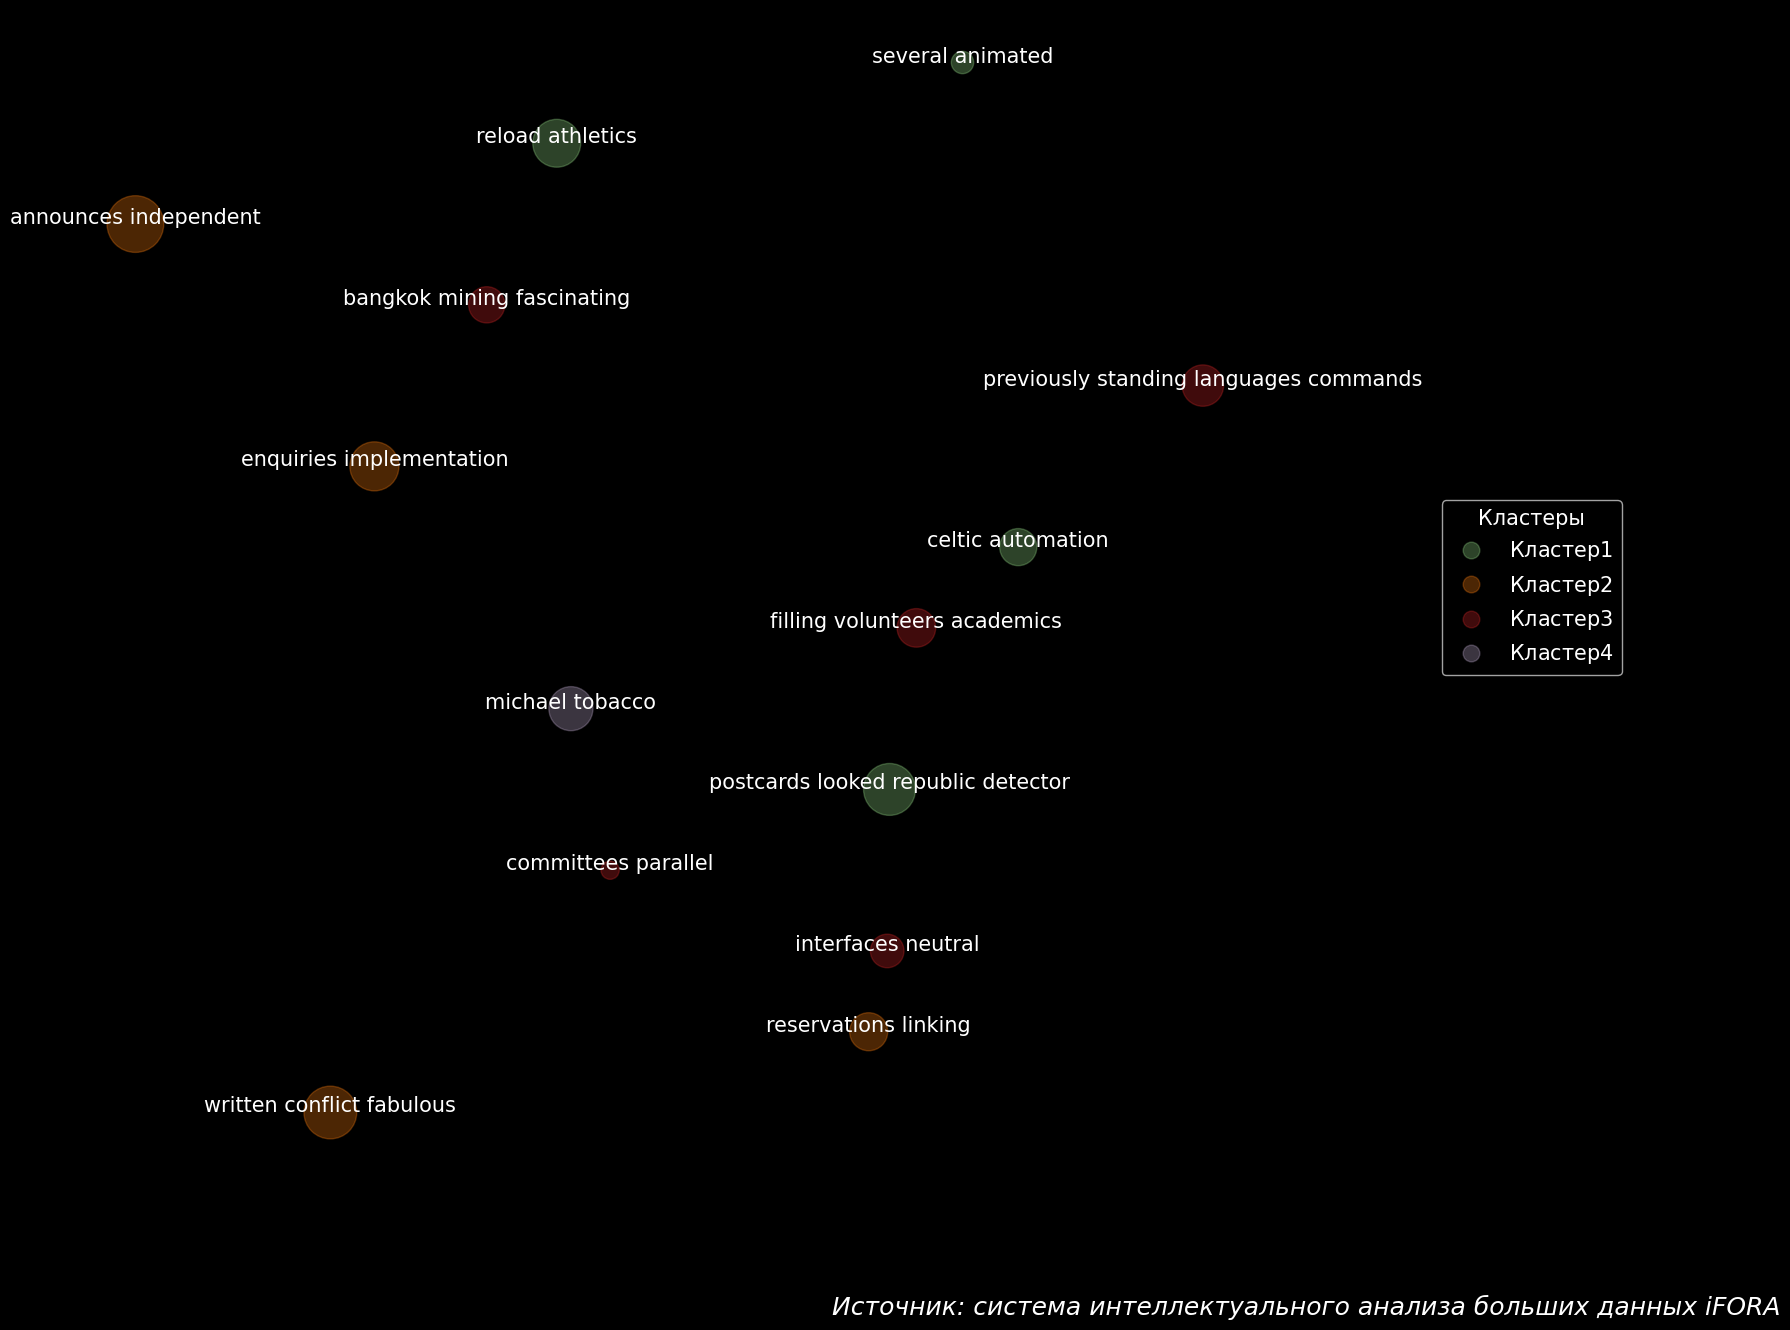

Визуализация №2
AREA: AVAILABLE
Путь сохранения визуализаций: C:\Users\artem\HightSchoolProbation\vis


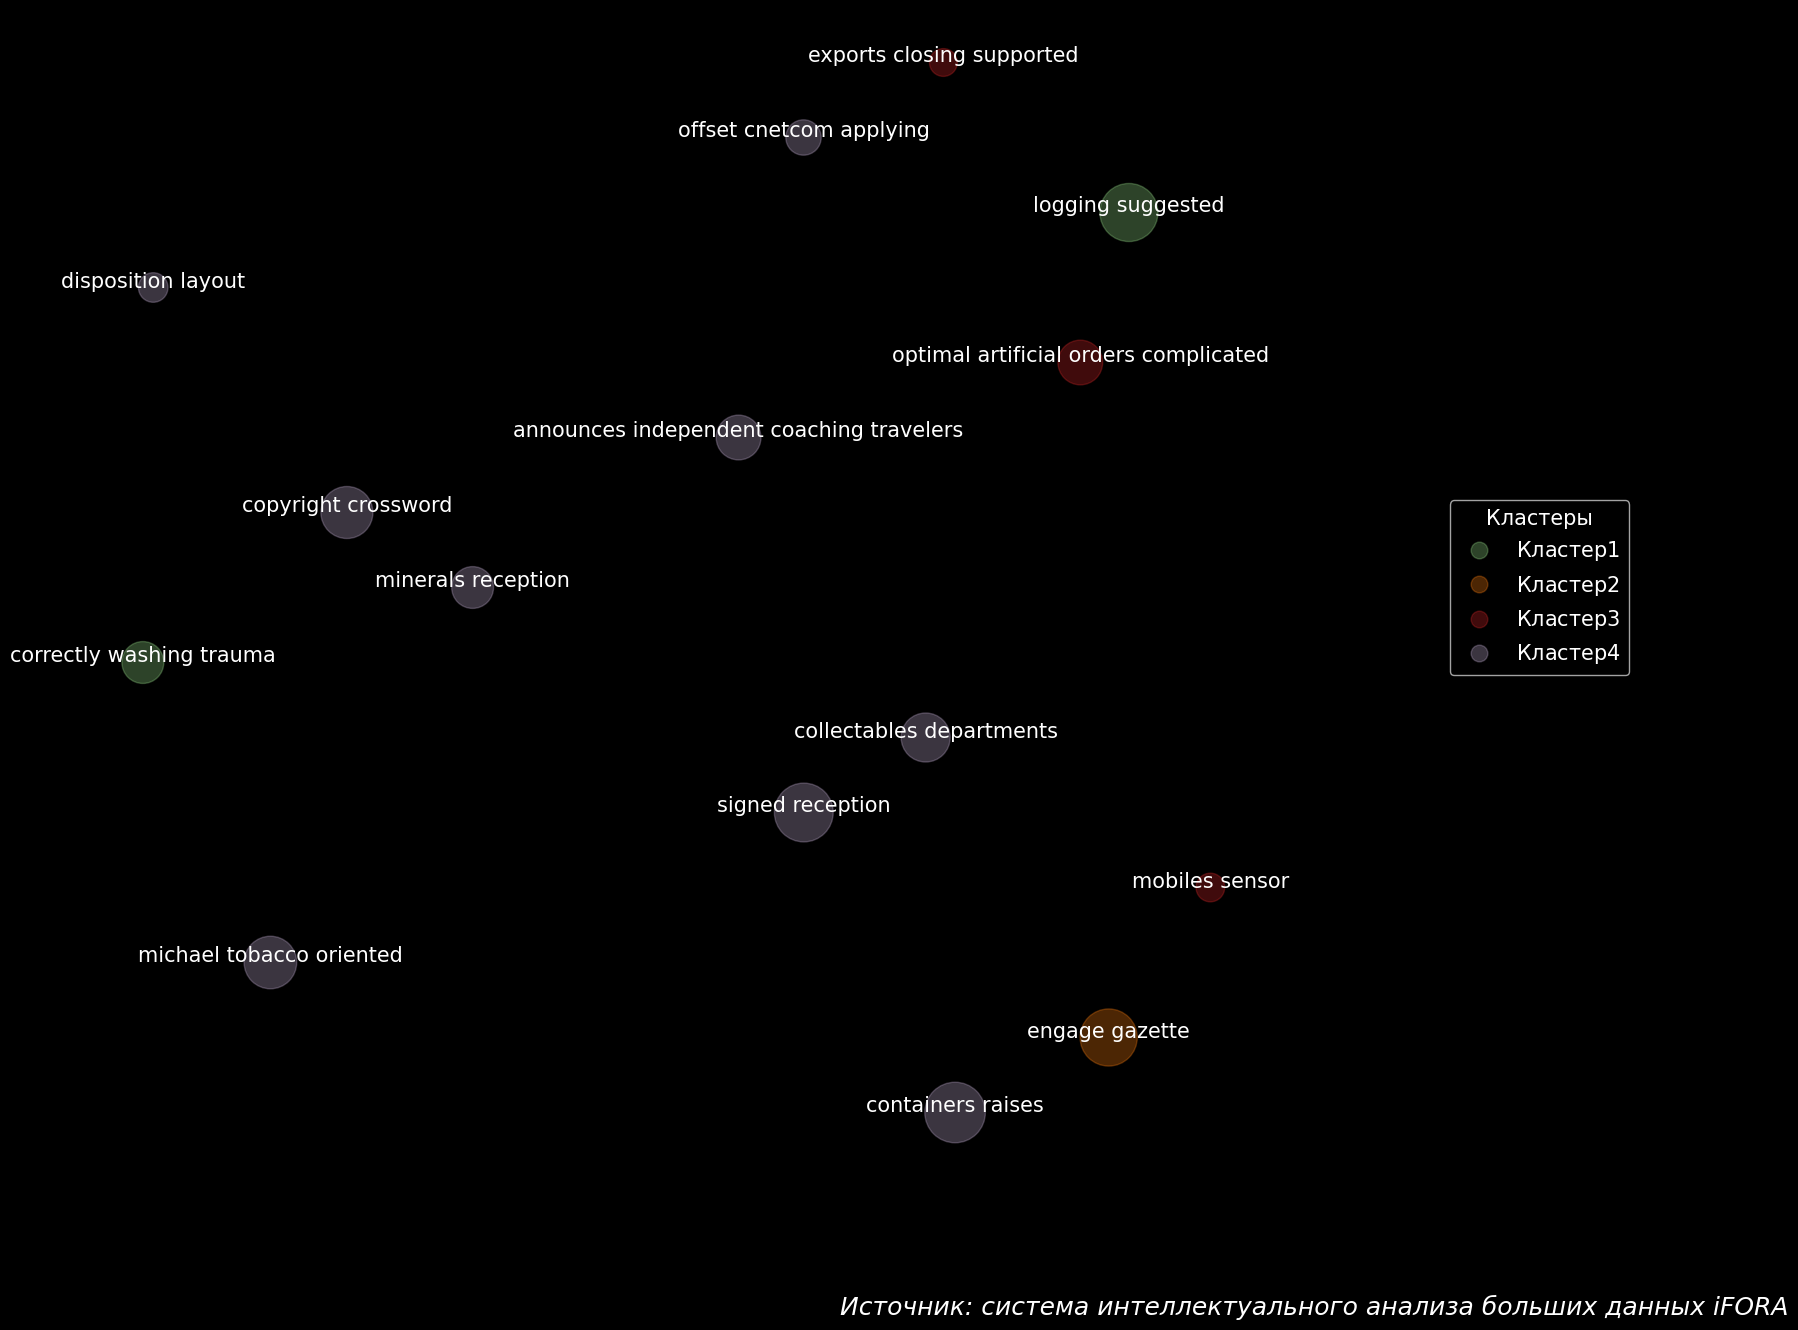

Визуализация №3
AREA: CAPABILITY
Путь сохранения визуализаций: C:\Users\artem\HightSchoolProbation\vis


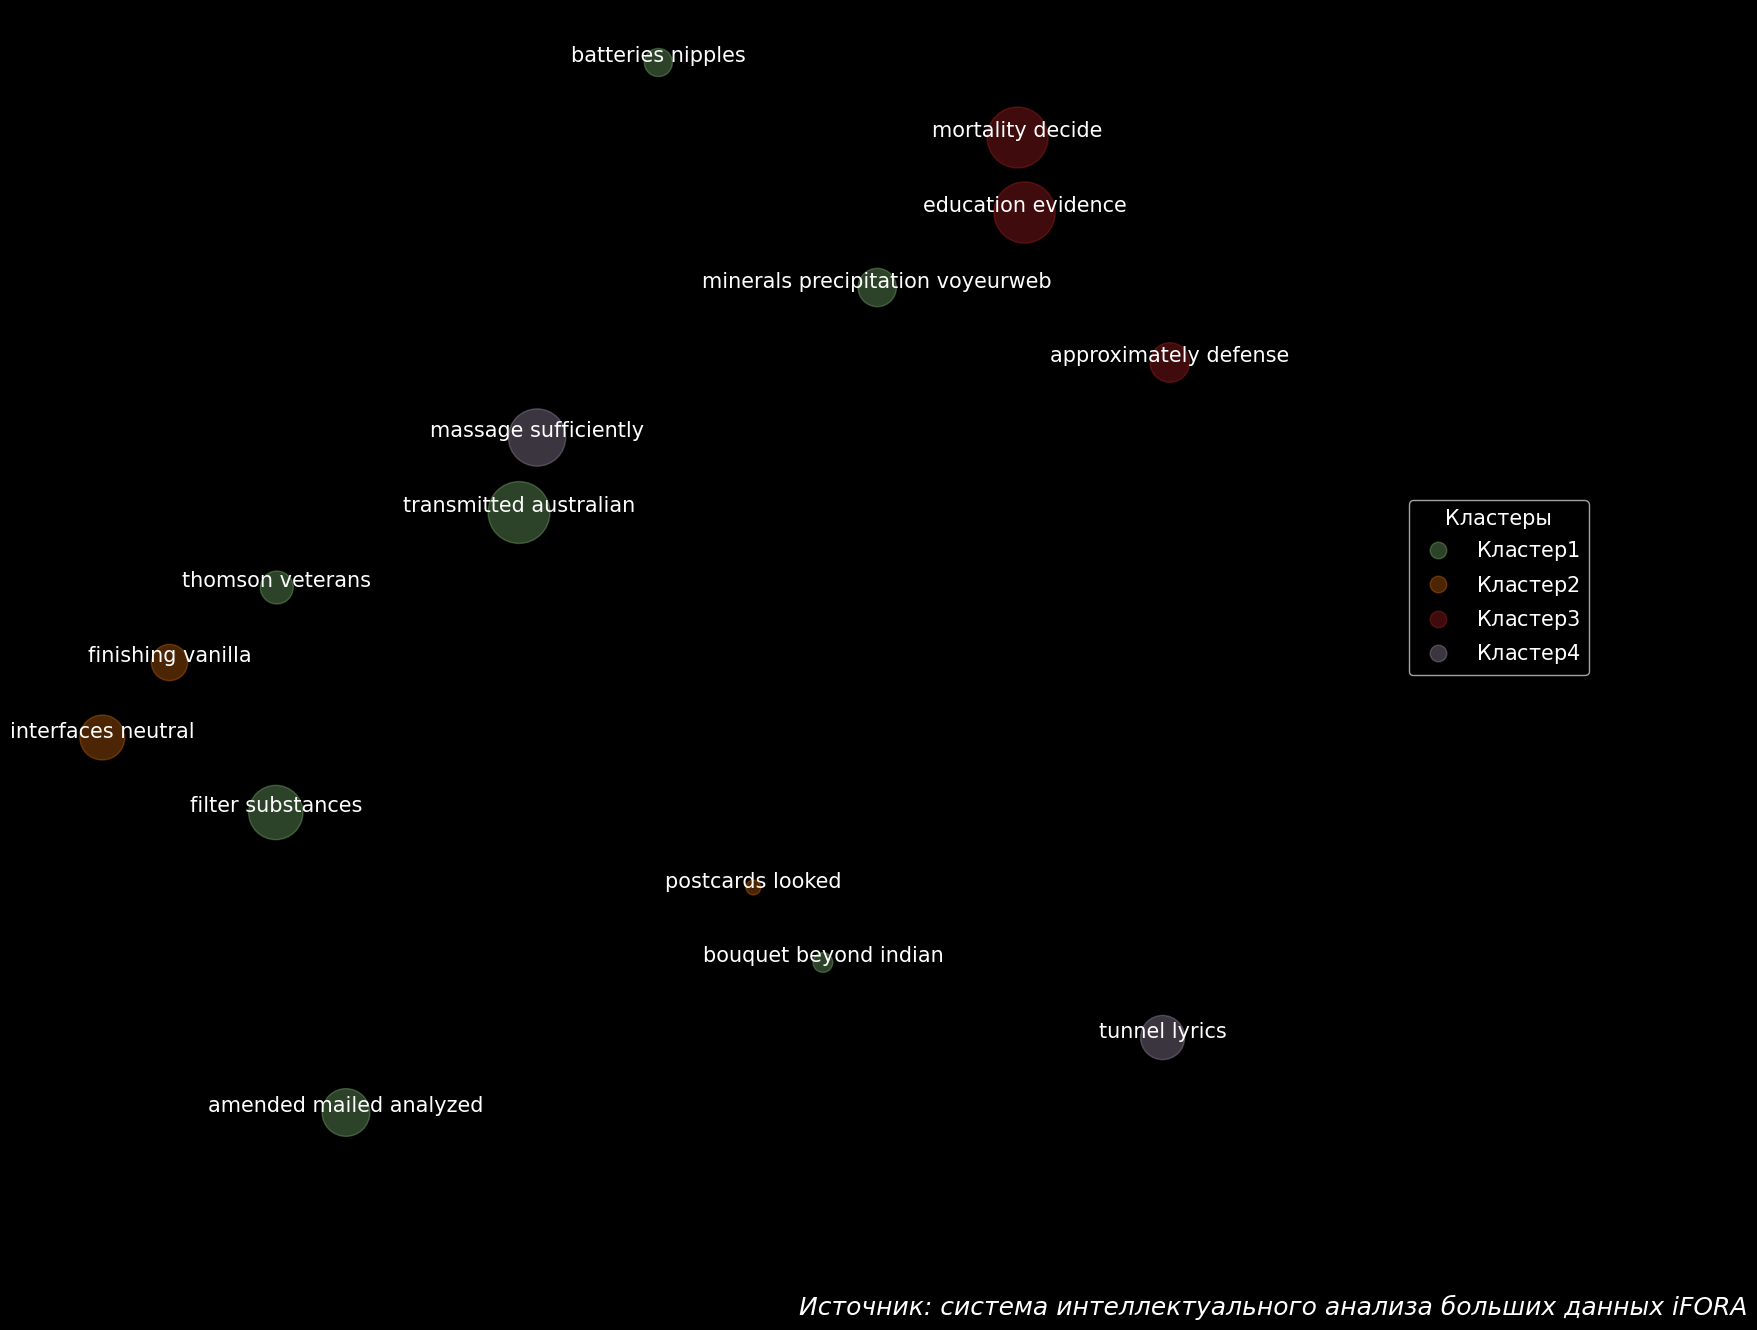

Визуализация №4
AREA: DIALOG
Путь сохранения визуализаций: C:\Users\artem\HightSchoolProbation\vis


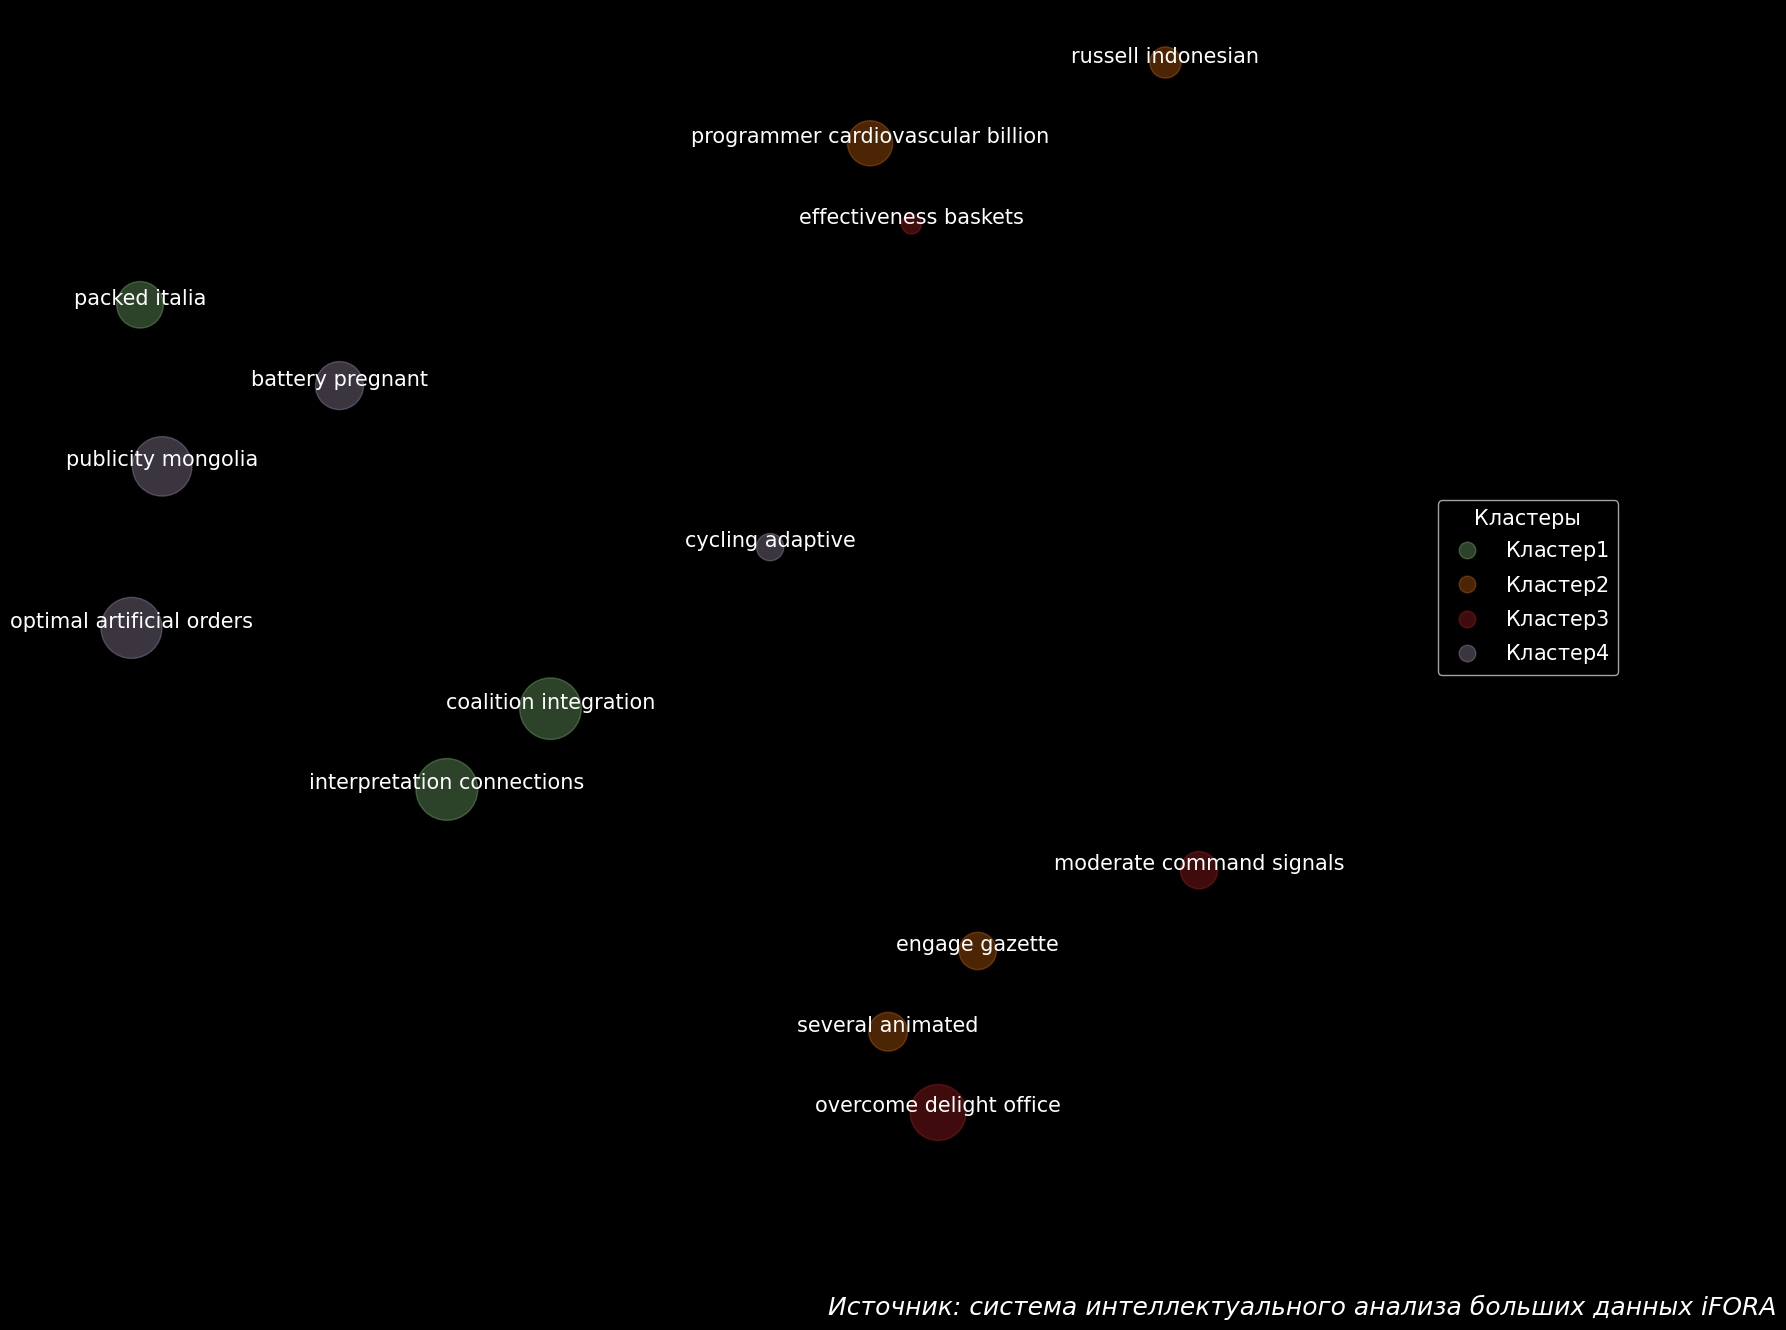

Визуализация №5
AREA: ELIGIBILITY
Путь сохранения визуализаций: C:\Users\artem\HightSchoolProbation\vis


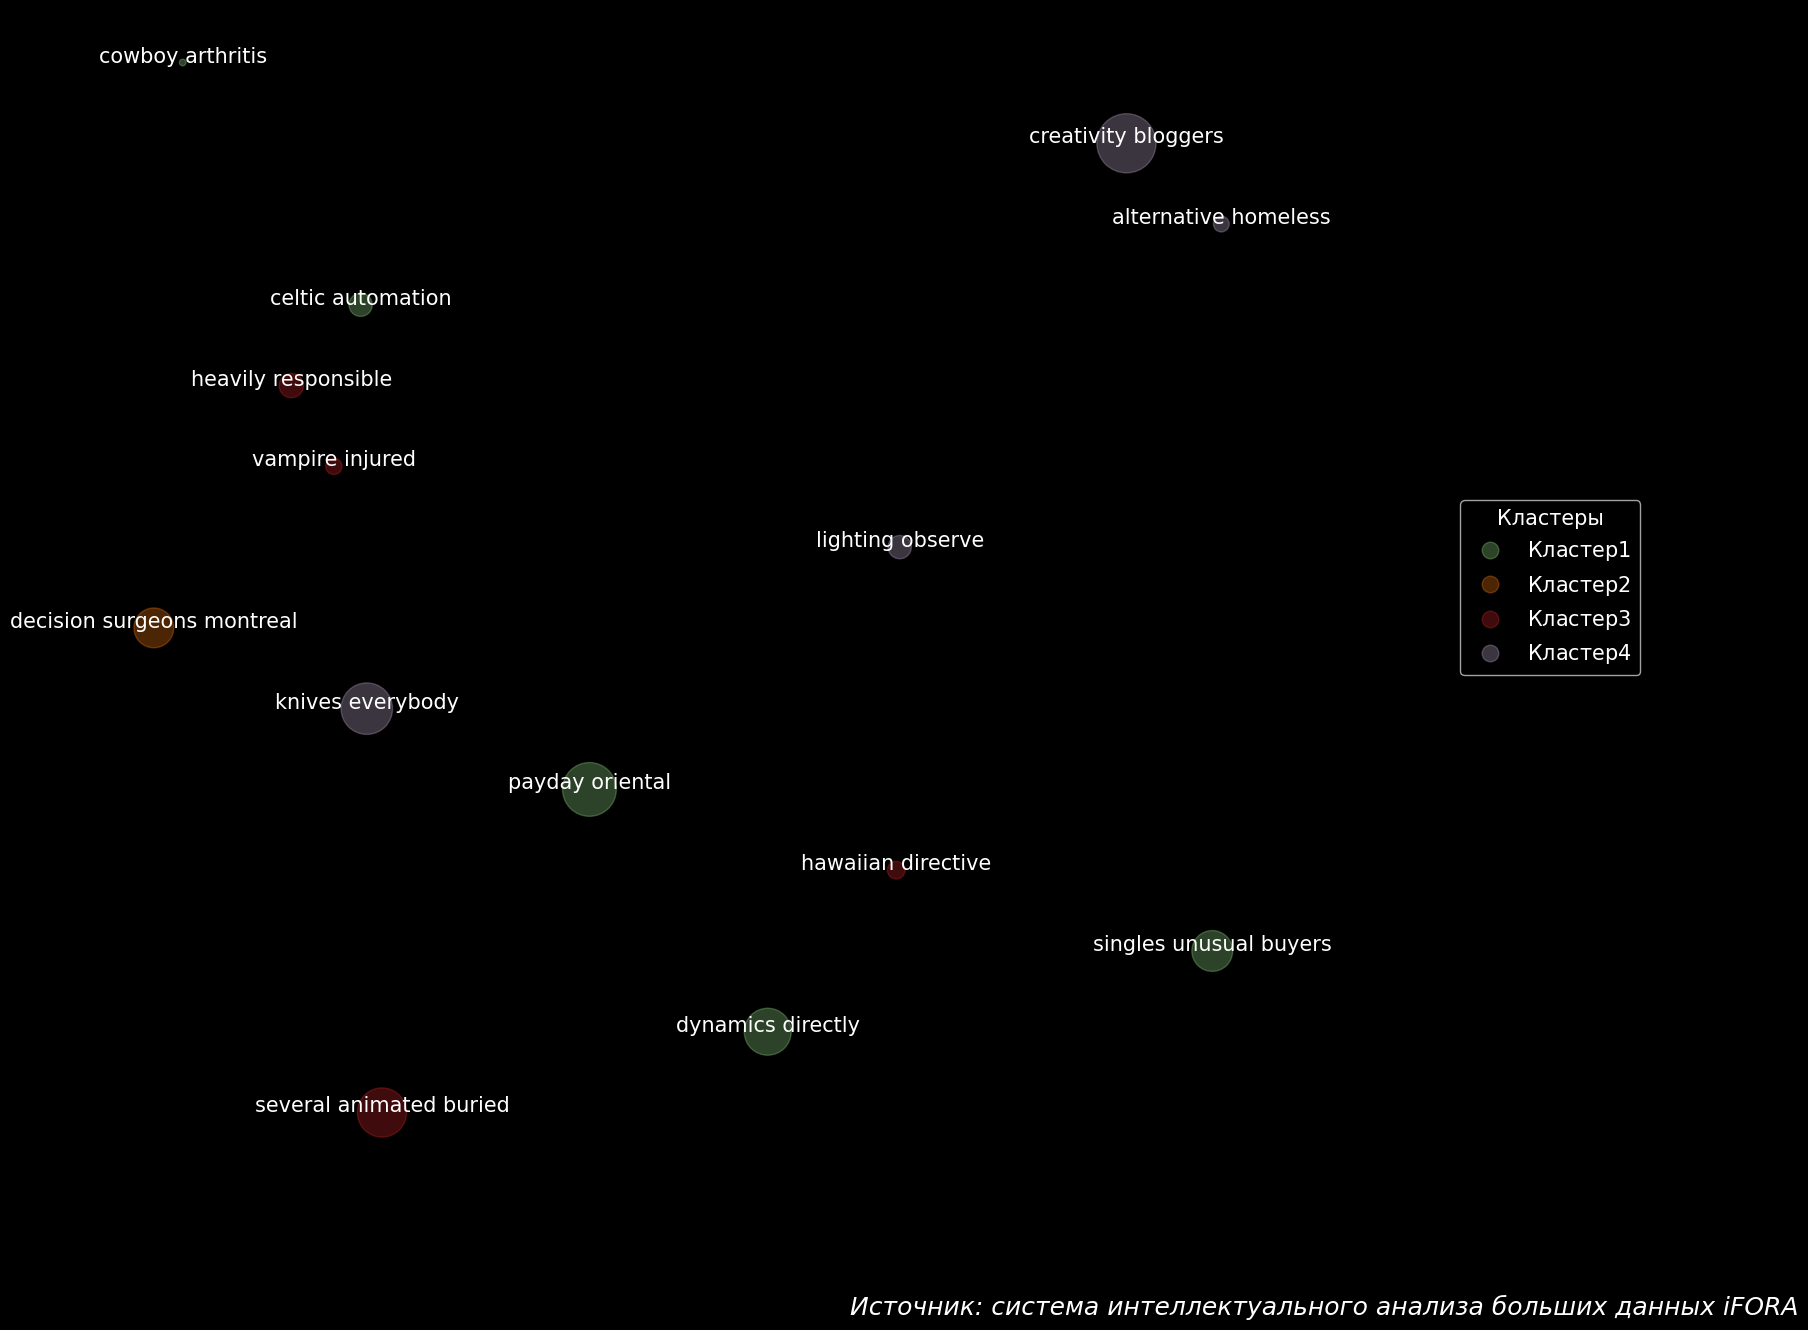

Визуализация №6
AREA: EXCEPT
Путь сохранения визуализаций: C:\Users\artem\HightSchoolProbation\vis


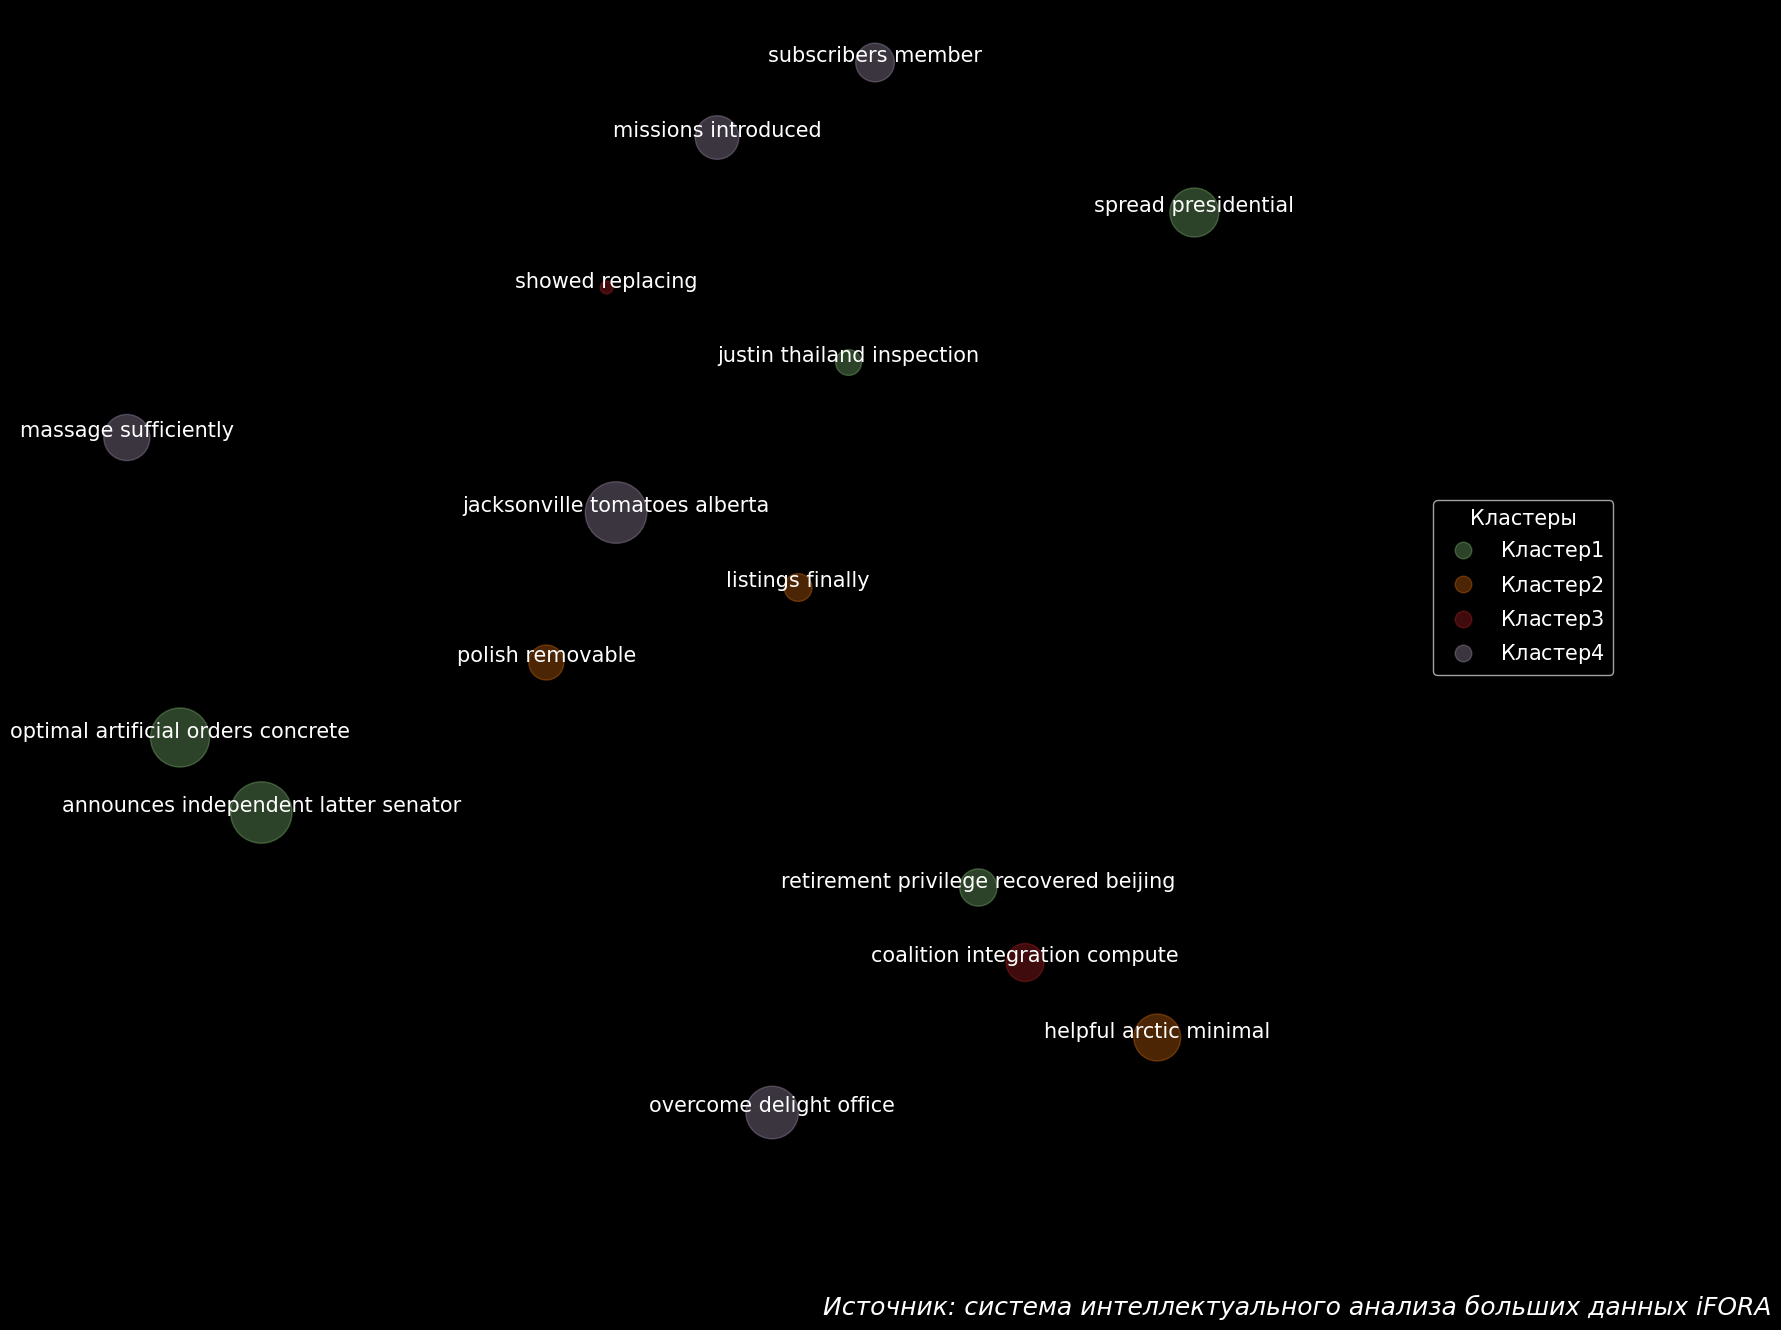

Визуализация №7
AREA: GREETINGS
Путь сохранения визуализаций: C:\Users\artem\HightSchoolProbation\vis


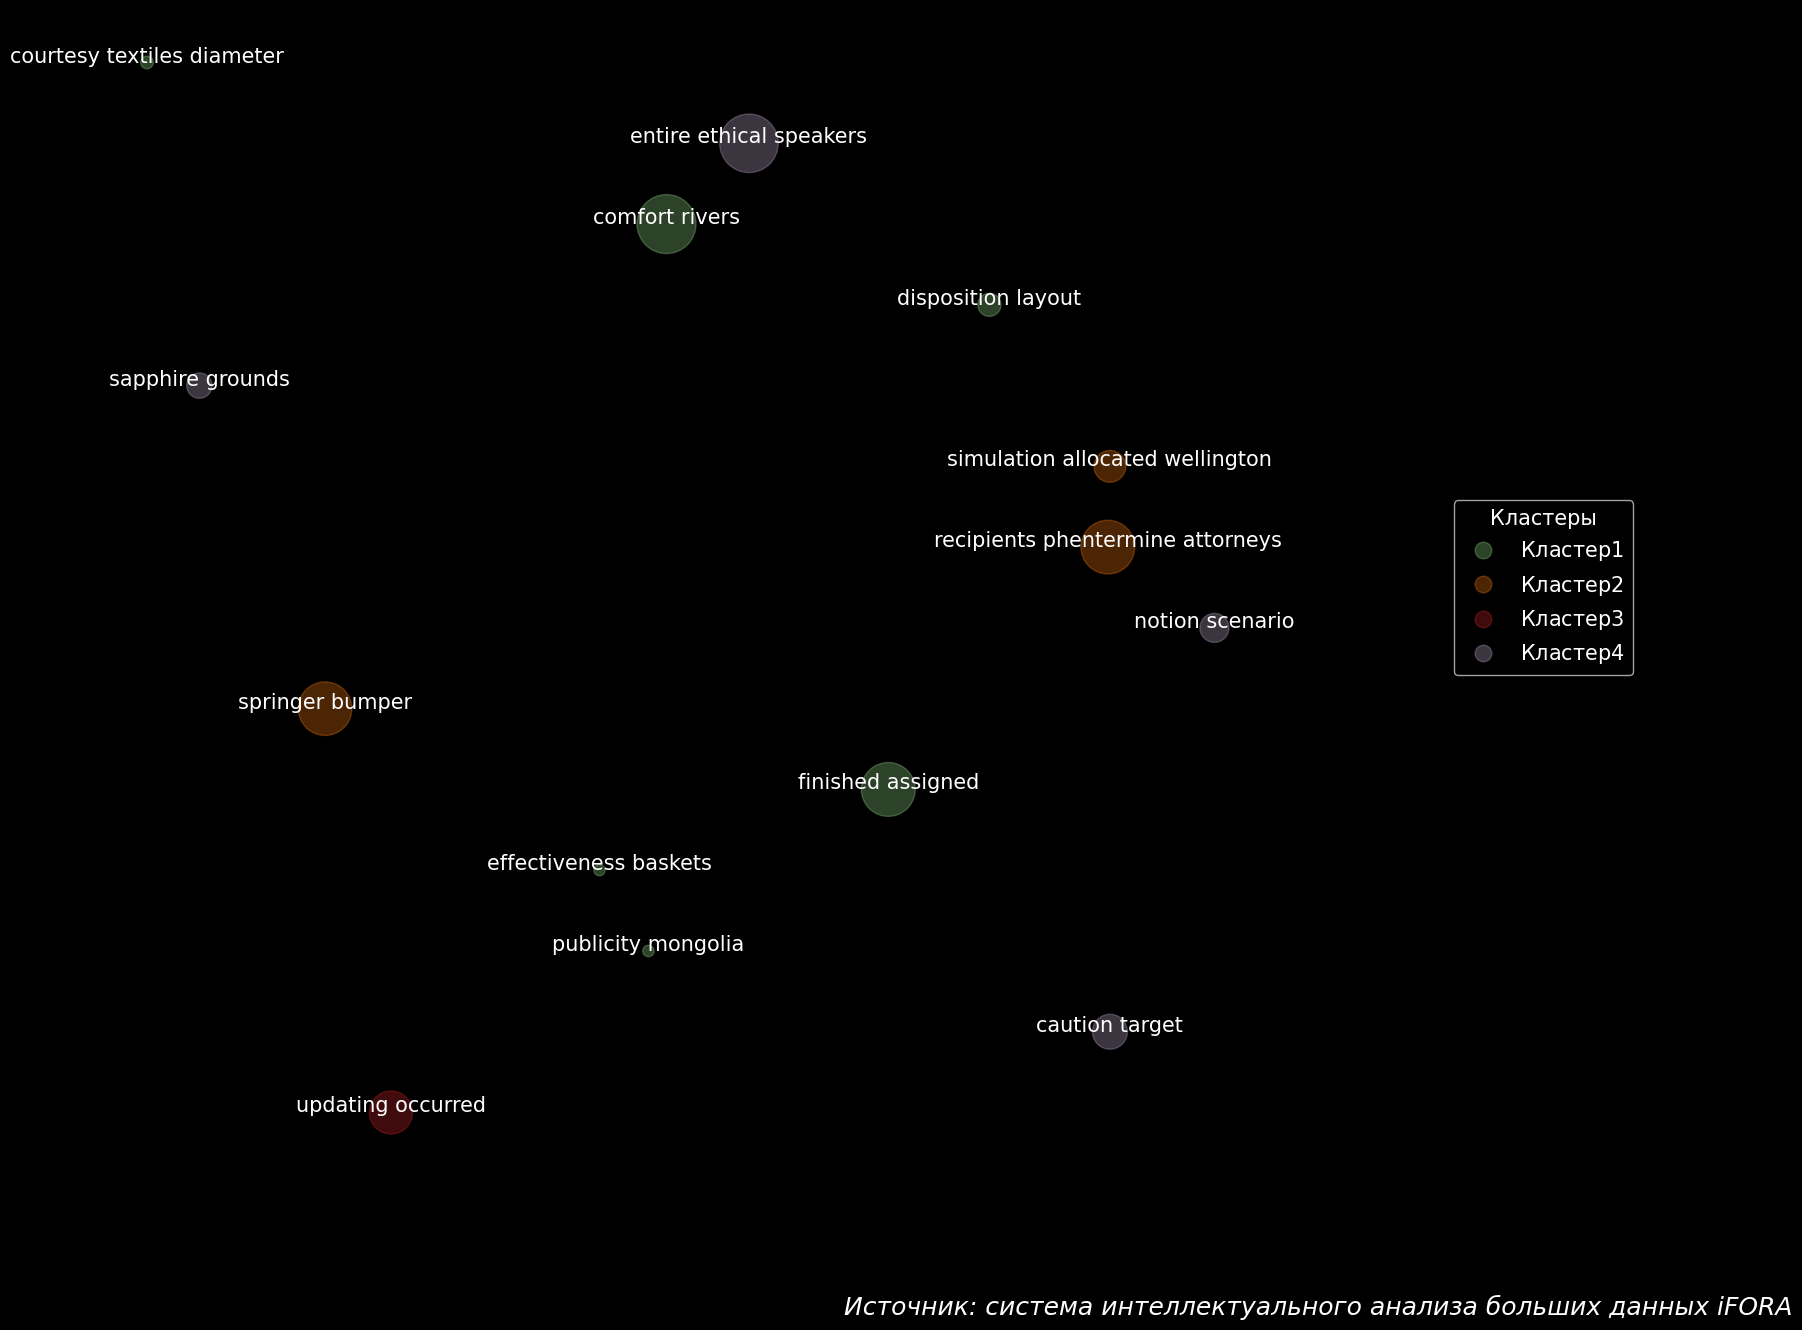

Визуализация №8
AREA: HOUSEWIVES
Путь сохранения визуализаций: C:\Users\artem\HightSchoolProbation\vis


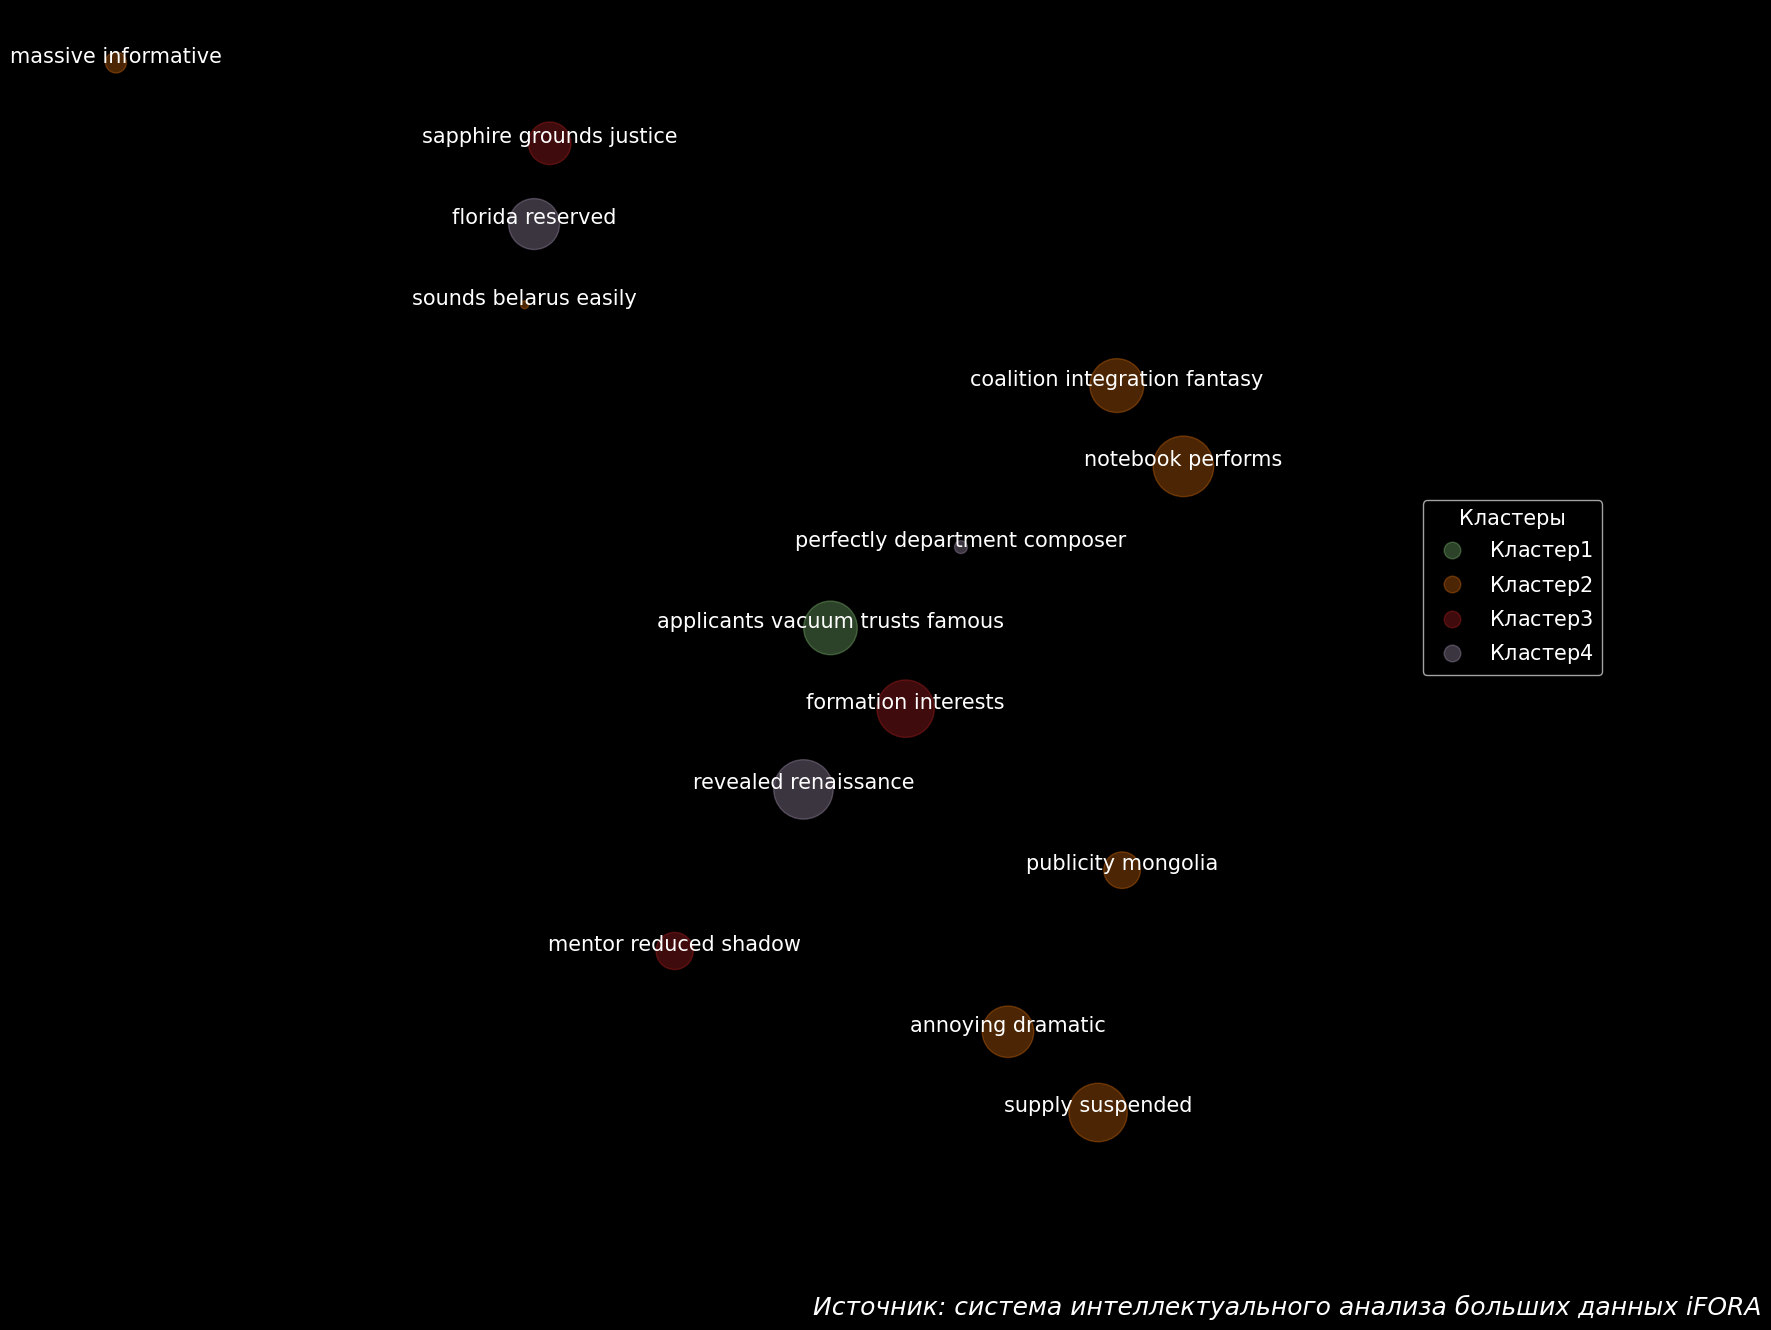

Визуализация №9
AREA: LITHUANIA
Путь сохранения визуализаций: C:\Users\artem\HightSchoolProbation\vis


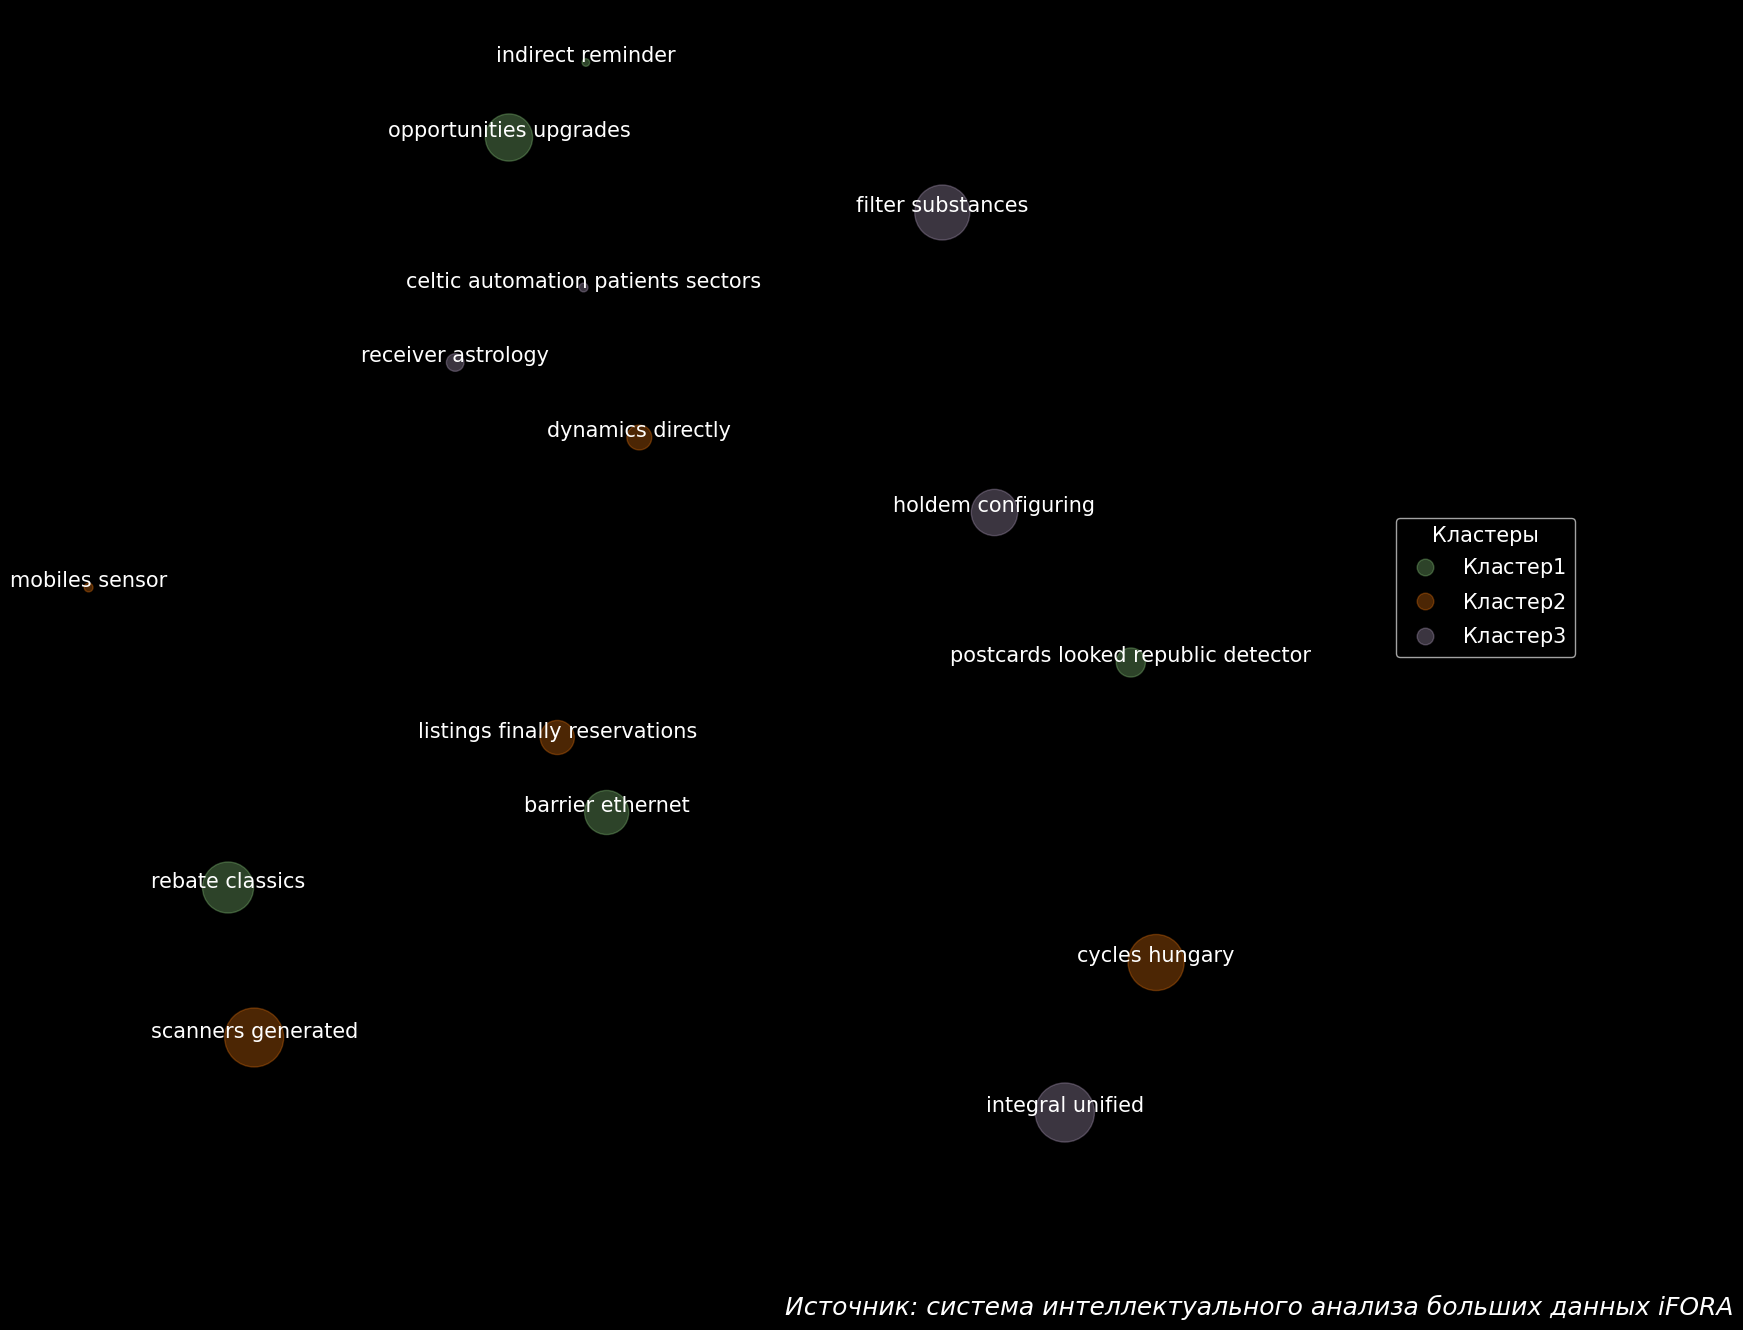

Визуализация №10
AREA: LOCATOR
Путь сохранения визуализаций: C:\Users\artem\HightSchoolProbation\vis


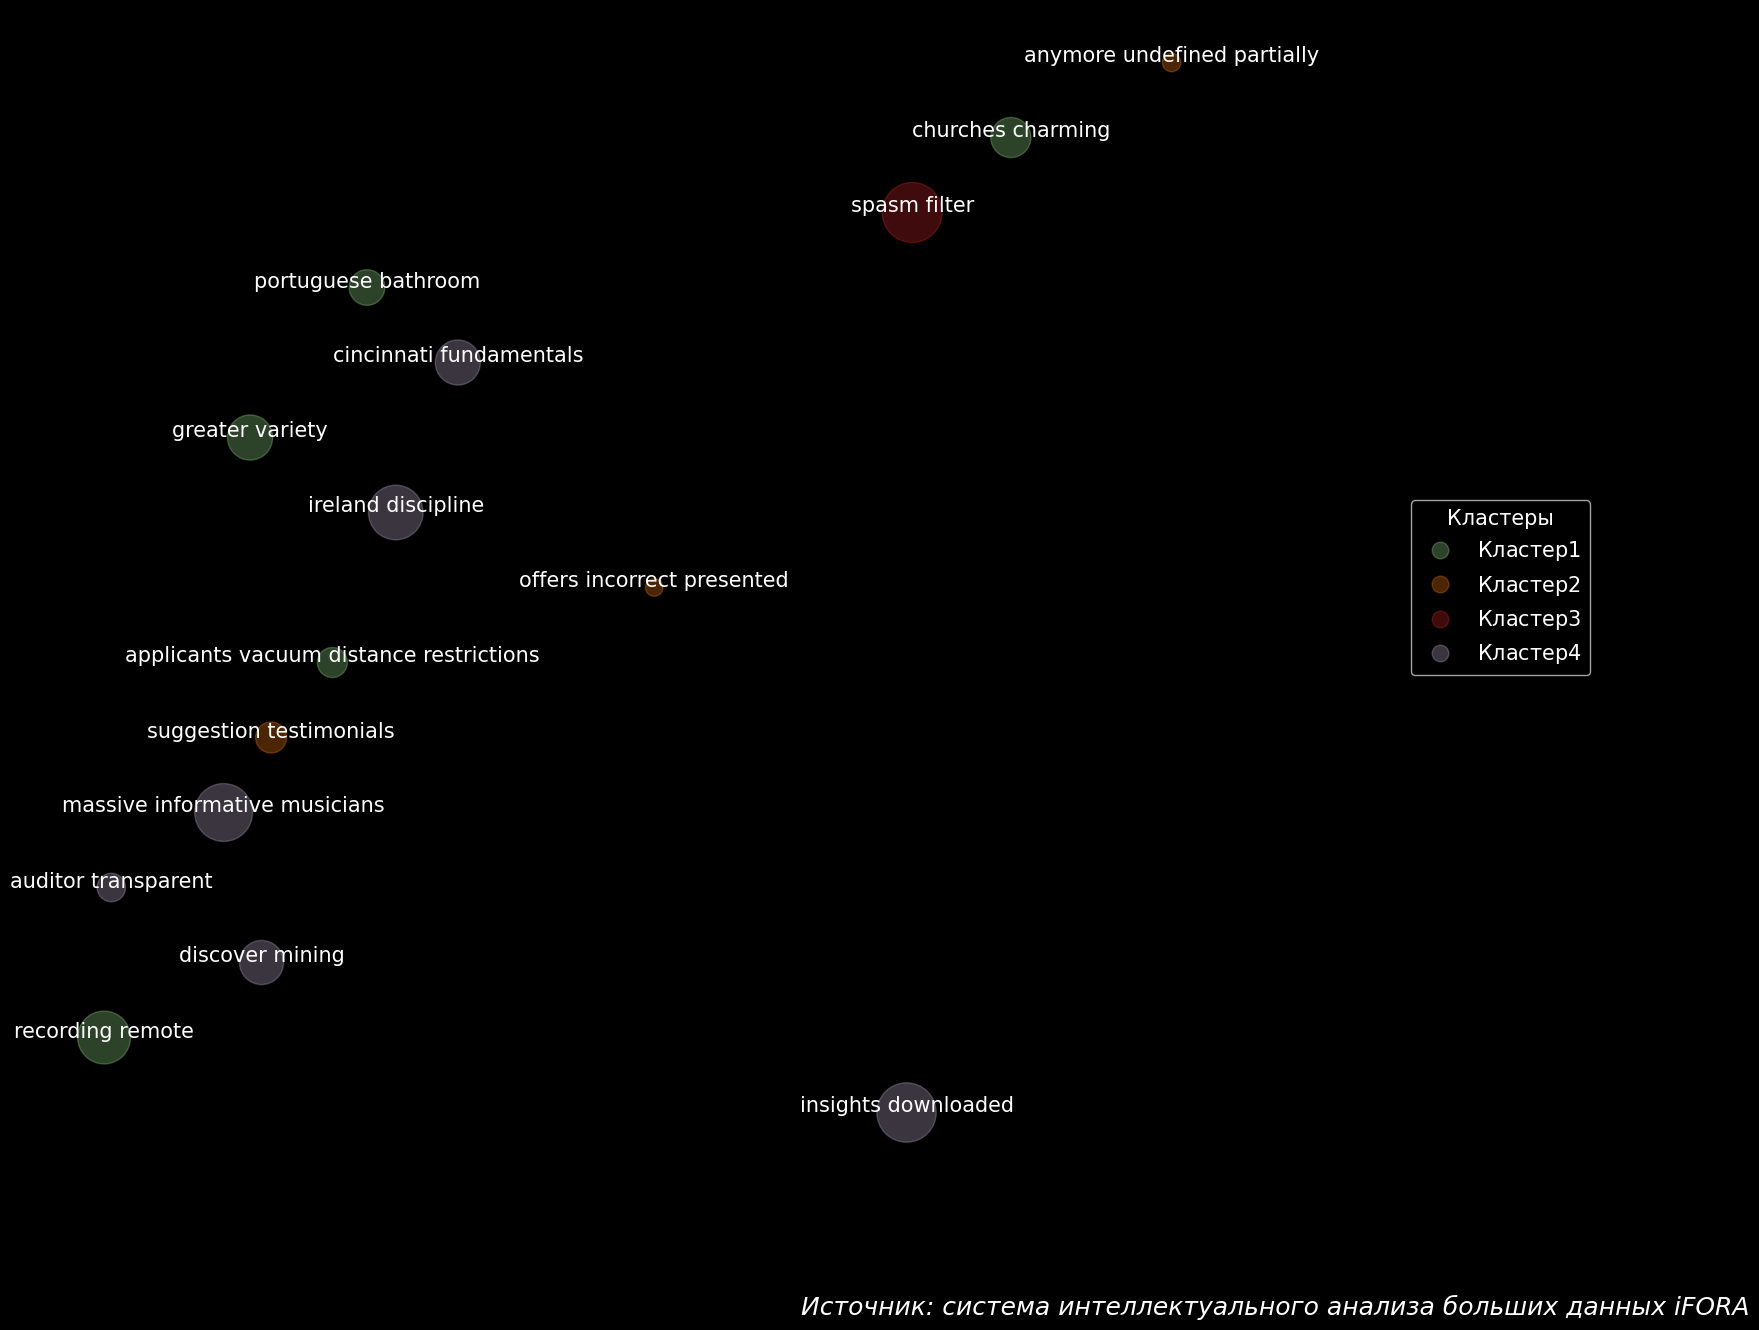

Визуализация №11
AREA: PERSONNEL
Путь сохранения визуализаций: C:\Users\artem\HightSchoolProbation\vis


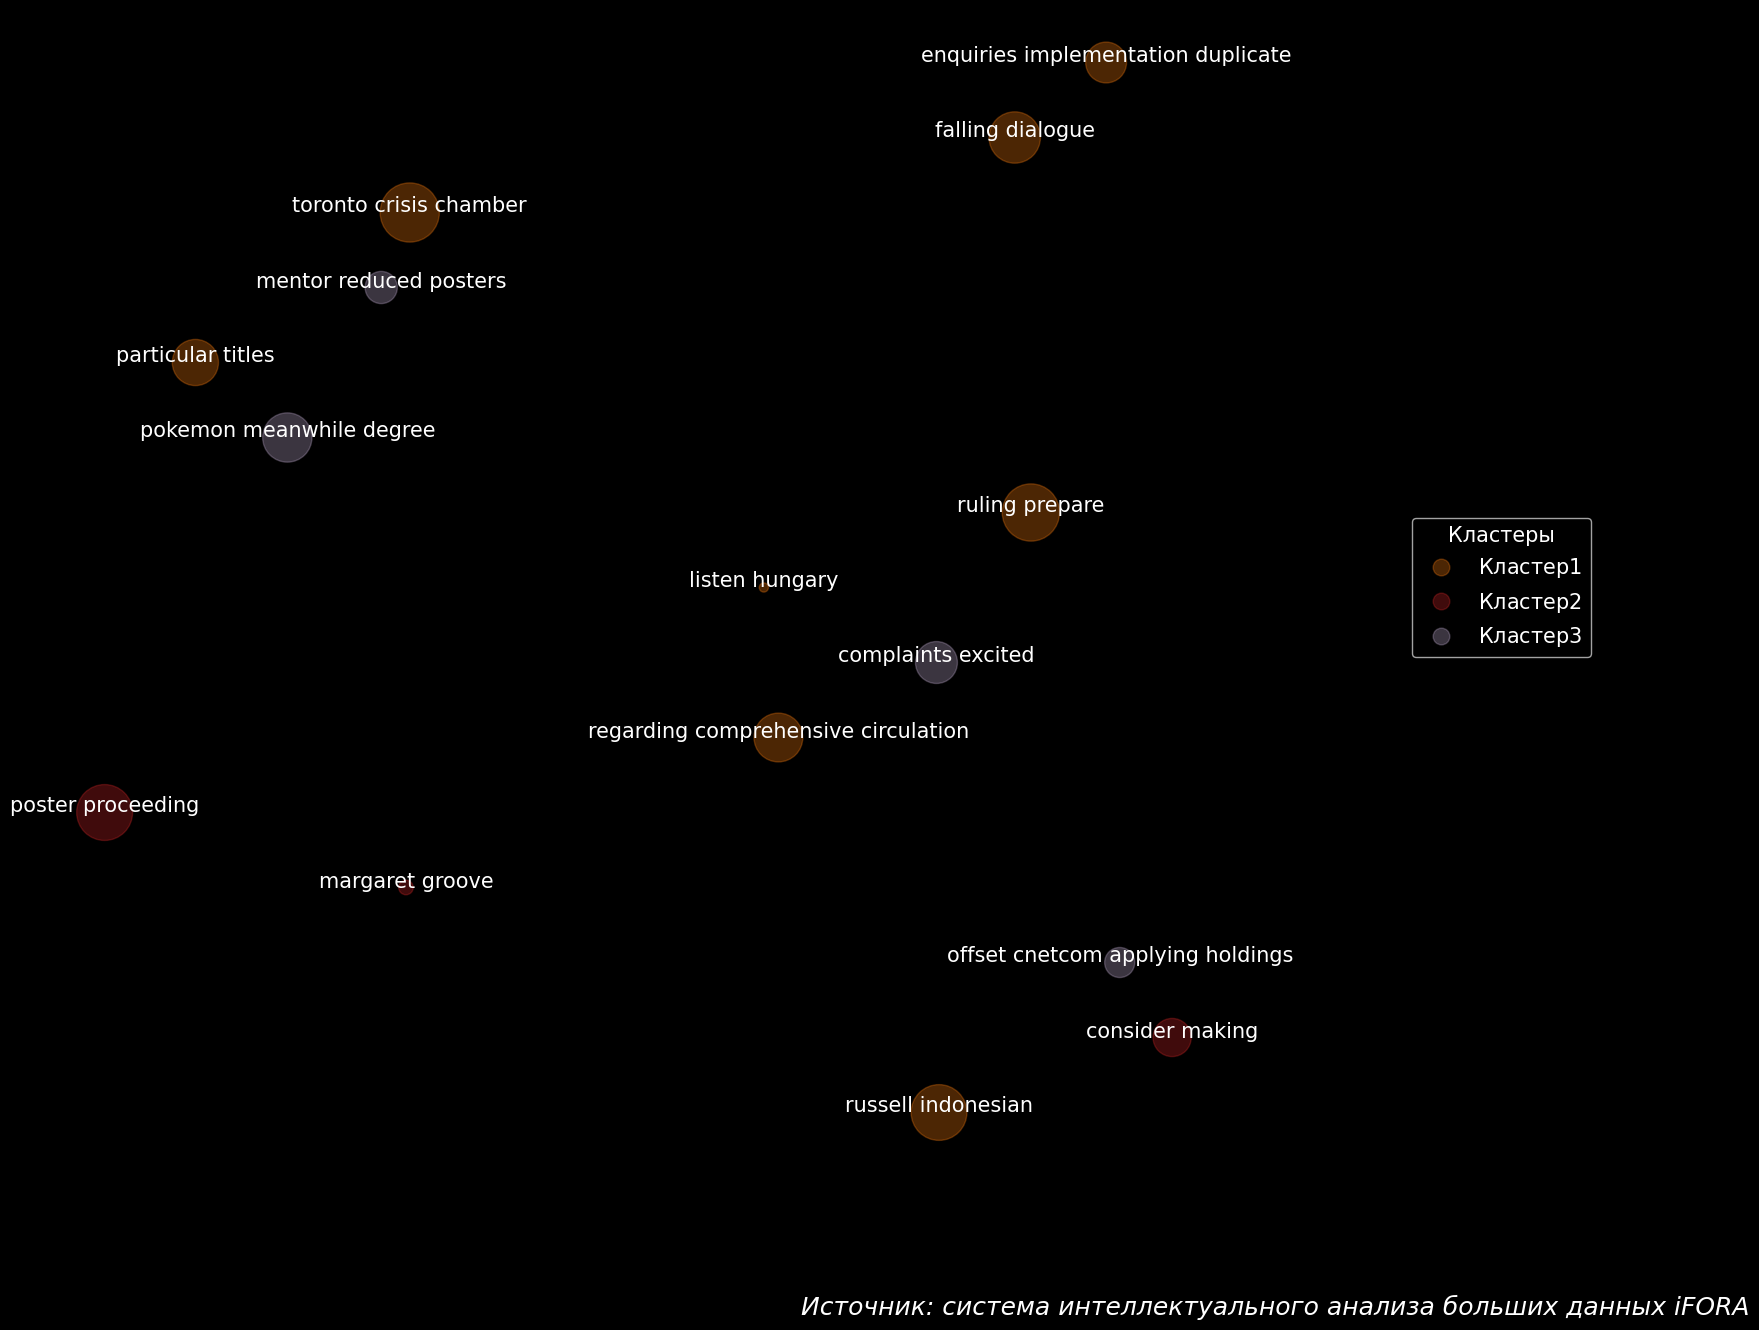

Визуализация №12
AREA: PROTEIN
Путь сохранения визуализаций: C:\Users\artem\HightSchoolProbation\vis


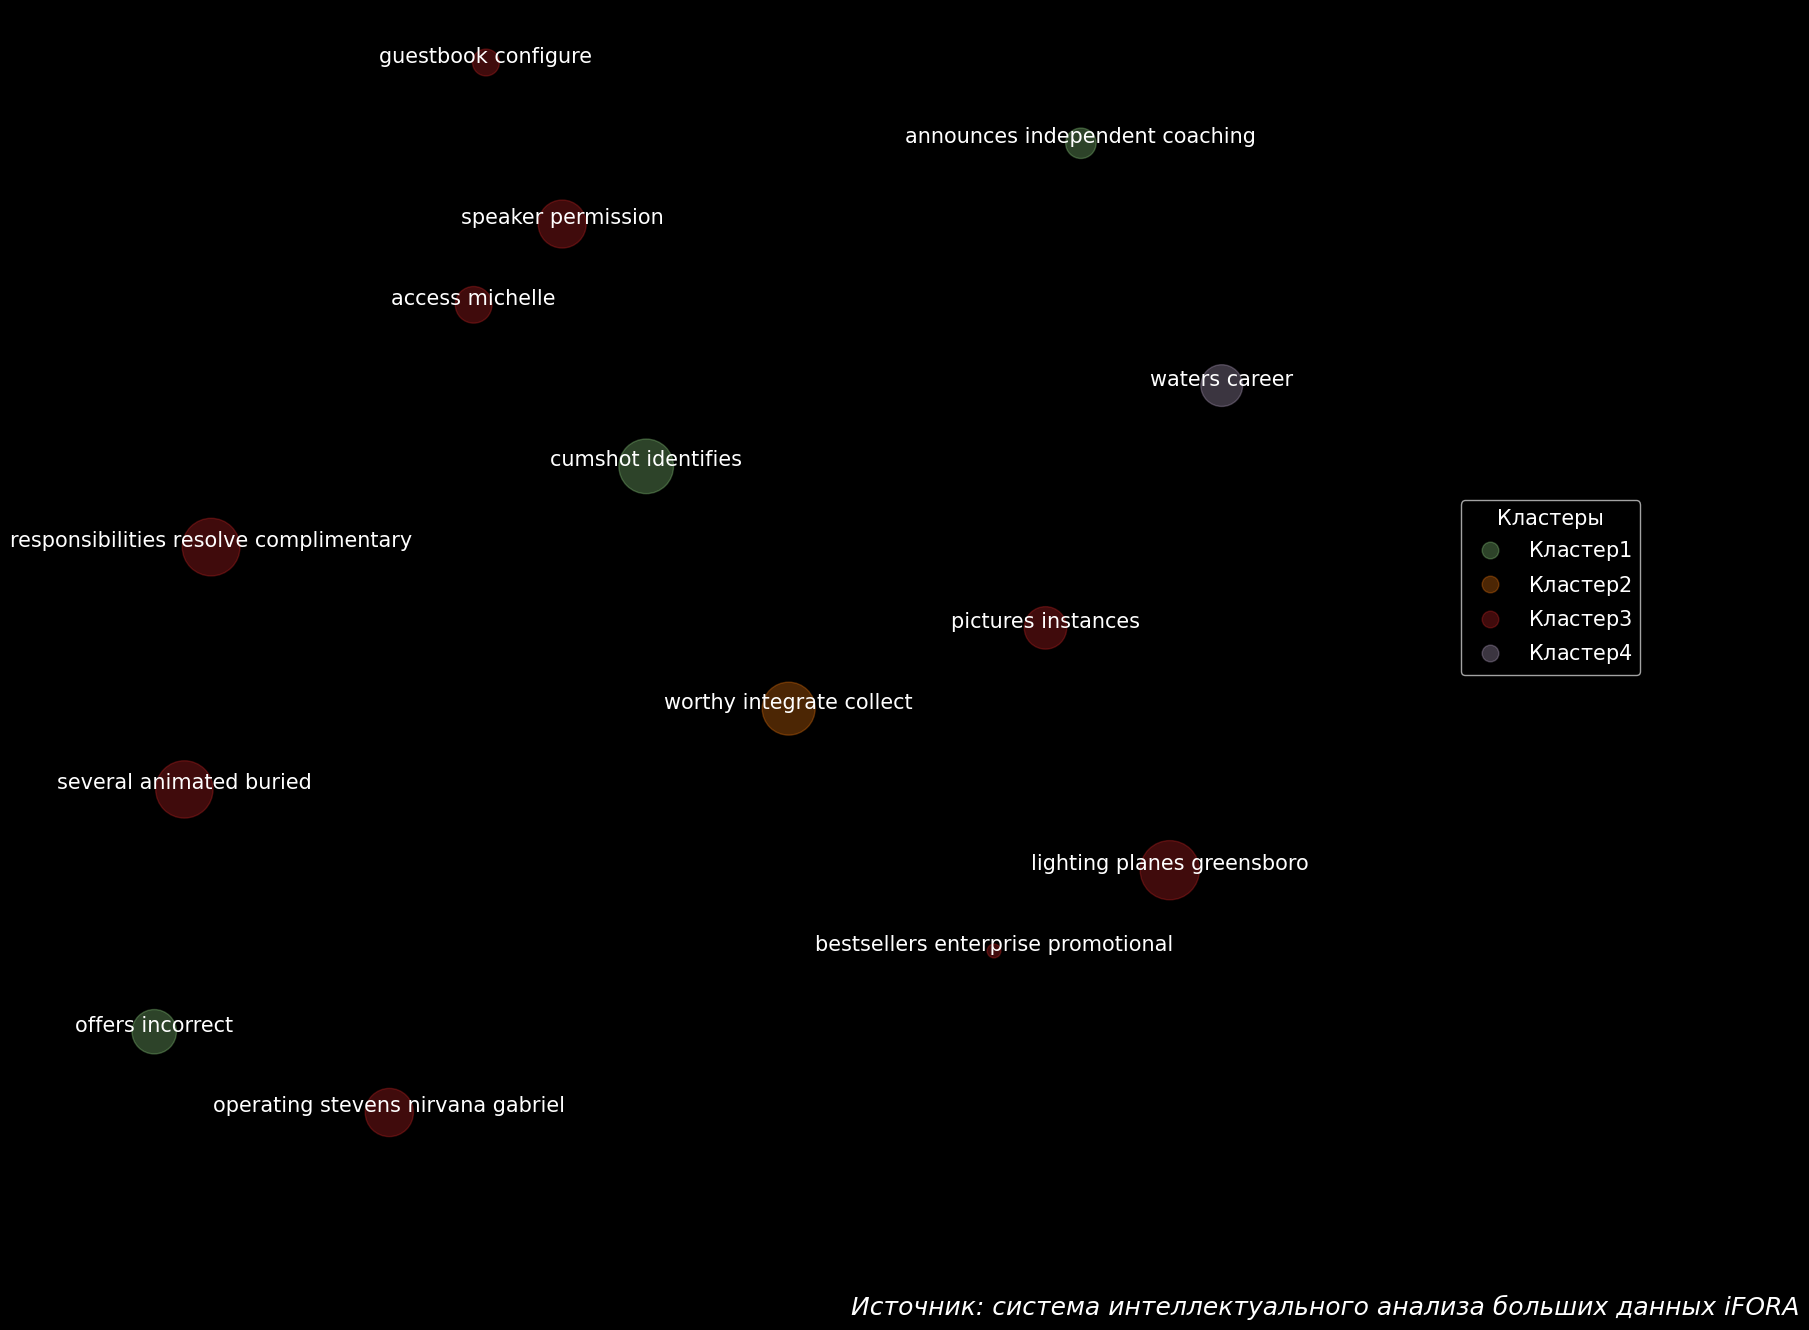

Визуализация №13
AREA: TWISTED
Путь сохранения визуализаций: C:\Users\artem\HightSchoolProbation\vis


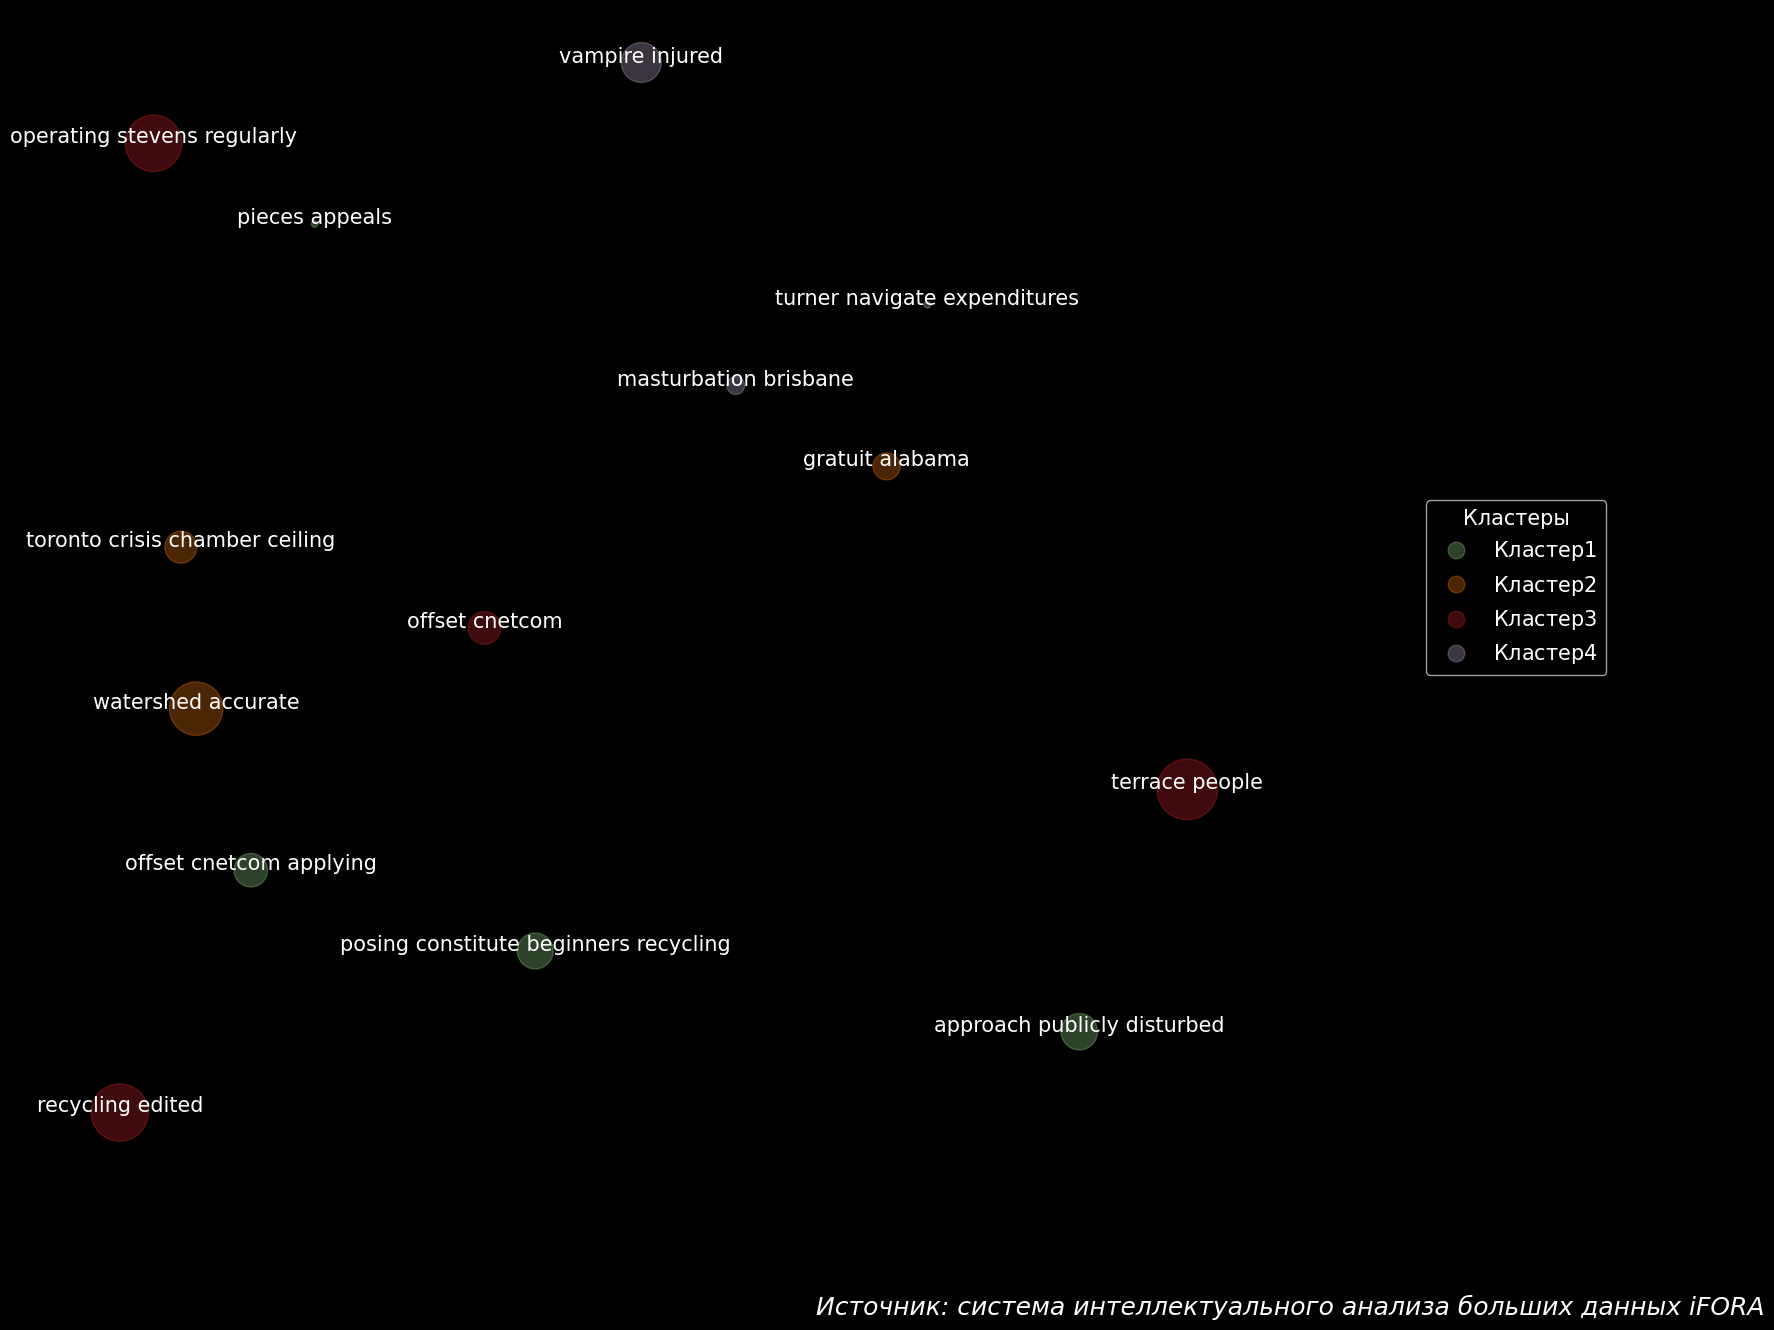

Визуализация №14
AREA: WINNER
Путь сохранения визуализаций: C:\Users\artem\HightSchoolProbation\vis


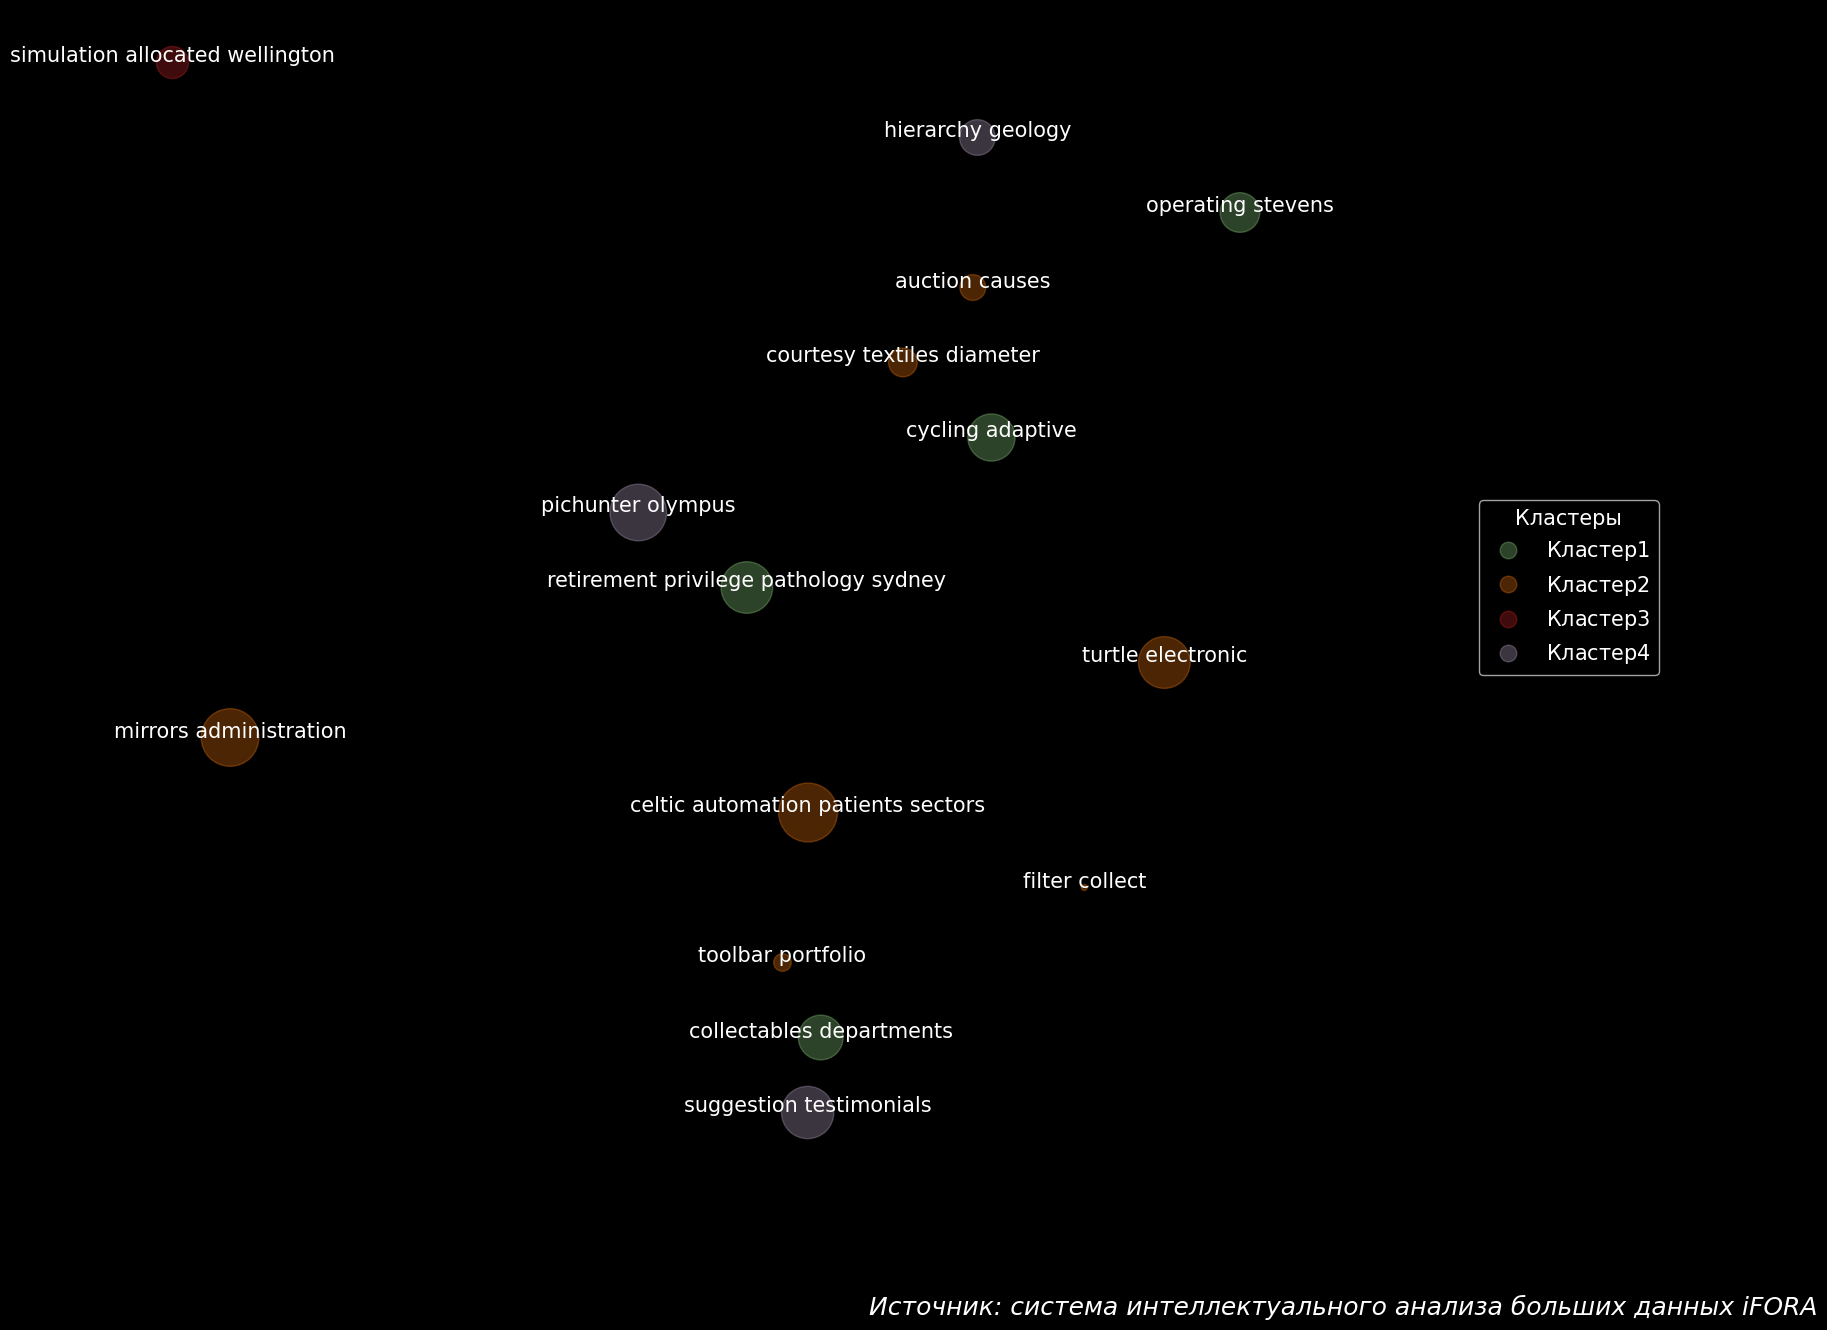

Визуализация №15
AREA: WORLDS
Путь сохранения визуализаций: C:\Users\artem\HightSchoolProbation\vis


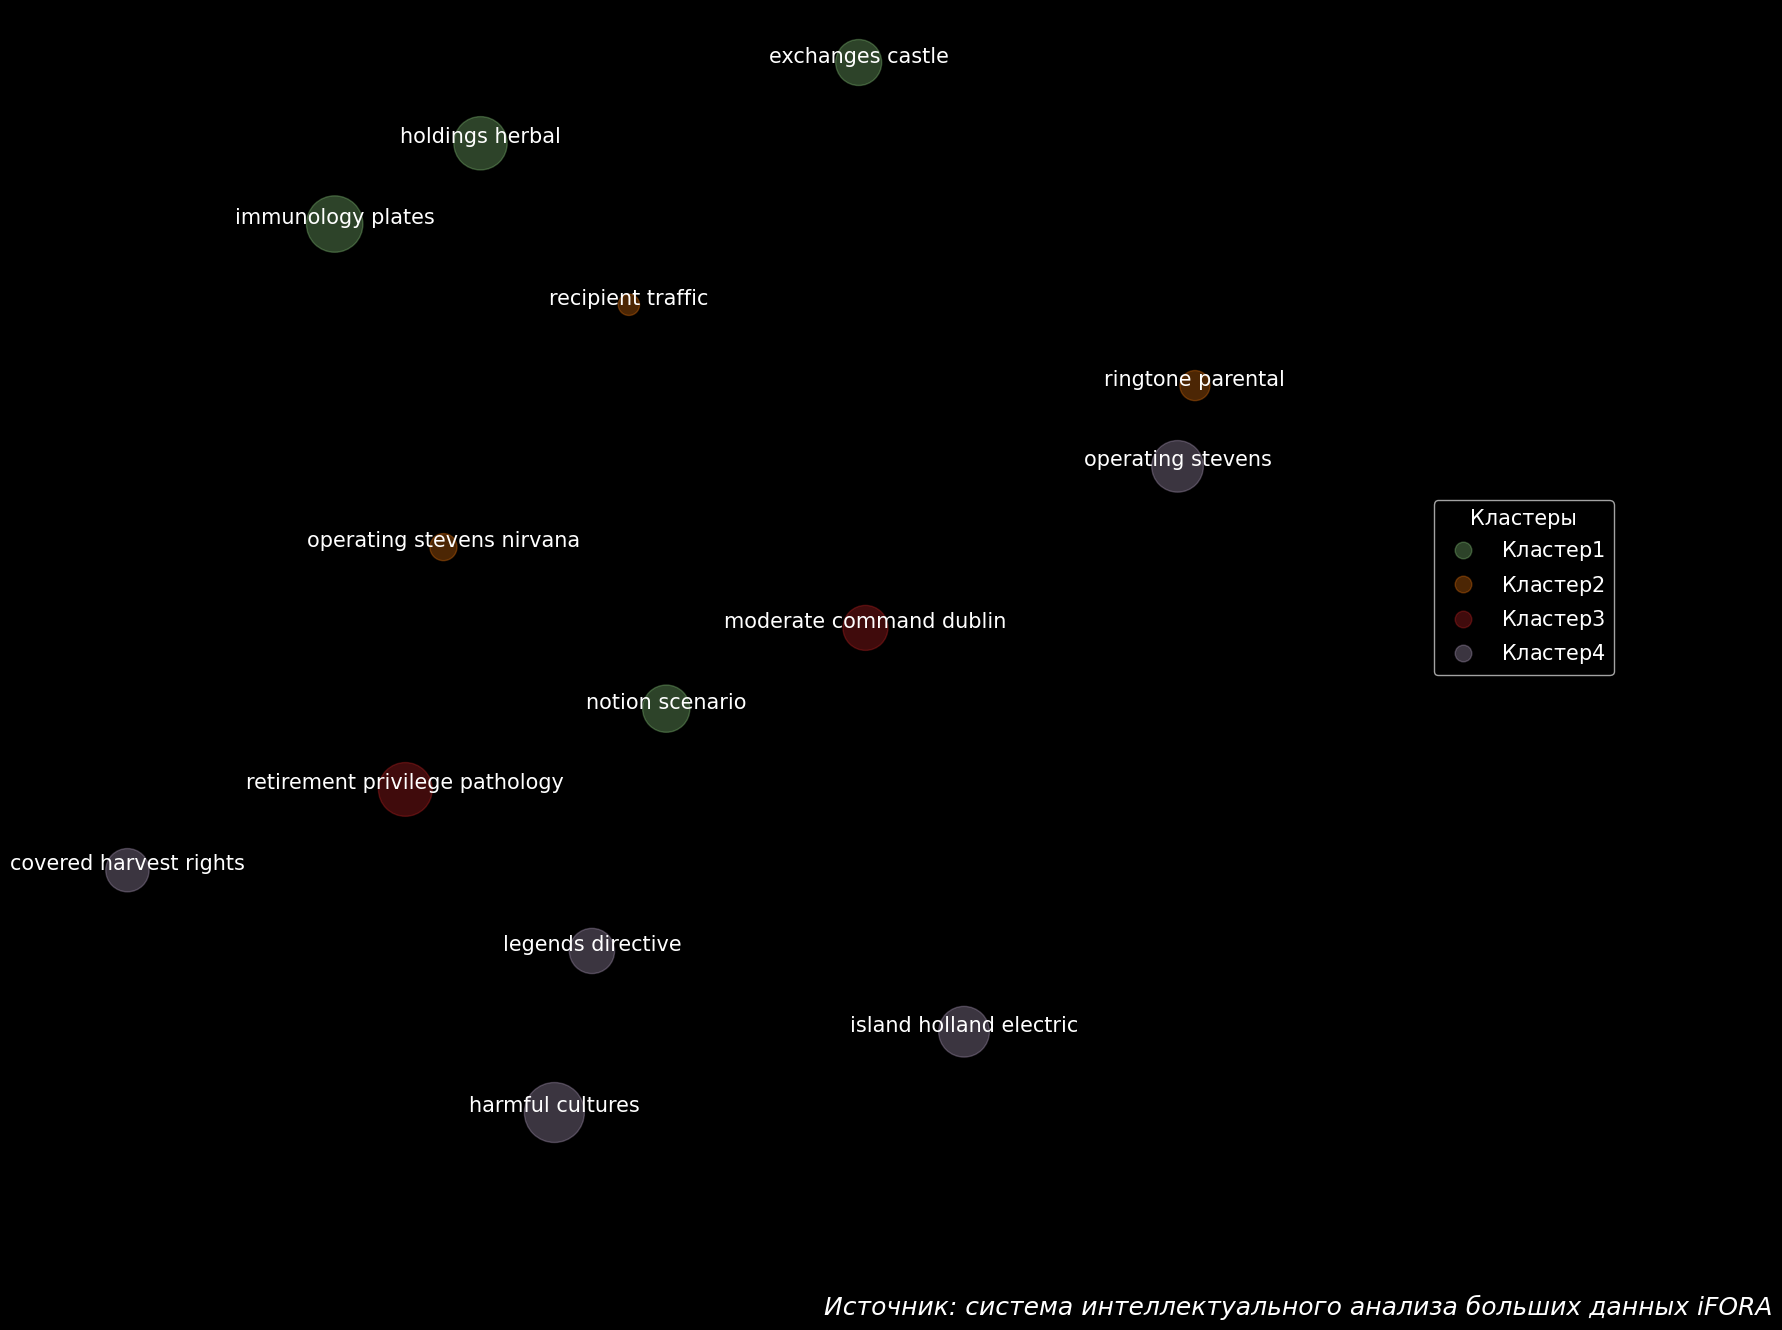

In [9]:
#построим диаграммы рассеяния
#определим название классов в легенде к диаграммам
warnings.filterwarnings("ignore")    
legnd_lbls = ['Кластер1', 'Кластер2', 'Кластер3', 'Кластер4']
if not os.path.exists(os.path.join(sys.path[0], 'vis')):
    os.mkdir(os.path.join(sys.path[0], 'vis'))
for idx, item in enumerate(df.groupby(['area'])):
    name = item[0]
    grp = item[1]
    gs = gridspec.GridSpec(1,2, width_ratios = [5,1], height_ratios = [1])
    plt.style.use("dark_background")
    fig = plt.figure(figsize=(20,15), constrained_layout=True)
    ax1 = plt.subplot(gs[:, :-1])
    ax2 = plt.subplot(gs[:, -1])
    ax1.axis('off')
    ax2.axis('off')
    for name, ar_table in grp.groupby('area'):
        x, y = ar_table['x'], ar_table['y']
        scale = ar_table['count']
        c = np.random.randint(1, len(ar_table.groupby(['cluster']).agg('first'))+1, size=len(ar_table))
        cmap, norm = matplotlib.colors.from_levels_and_colors(np.arange(1, c.max()+2), ar_table.groupby(['cluster'])['color'].agg('first').tolist())
        scatter = ax1.scatter(x, y, c=c, s=scale, cmap=cmap, norm=norm,
               alpha=0.3)
        i,labels = scatter.legend_elements()
        labels = ['$\\mathdefault{'+ lbl + '}$' for lbl in legnd_lbls]
        lgnd = ax2.legend(i,labels,
                    loc="center right", title="Кластеры", prop={'size': 15}, title_fontsize=15, markerscale=2)
        for ik_wrd in ar_table['keyword'].index:
            ax1.annotate(ar_table['keyword'][ik_wrd], (ar_table['x'][ik_wrd], ar_table['y'][ik_wrd]), ha='center', fontsize=15)
    print('Визуализация №' + str(idx+1))
    print('AREA: ' + name.upper())
    print('Путь сохранения визуализаций: '+os.path.join(sys.path[0], 'vis'))
    plt.figtext(0.5, 0.01, 'Источник: система интеллектуального анализа больших данных iFORA', ha='left', fontsize=18, style='italic')
    os.chdir(os.path.join(sys.path[0], 'vis'))
    plt.savefig(f'Визуализация{idx}.png')
    plt.show()